Aidan Rabinowitz-2341197-https://www.kaggle.com/aidanrabinowitz


The following notebook explores different approaches to solving the Spaceship Titanic Kaggle problem. Four different engineers approached this problem in four parts: Cleaning up the dataset (filling in empty values and evaluating which columns are important and why); Feature engineering (adding columns based on logically understanding how the data can be expanded, and how columns relate to others in special ways); and applying the data to six different Machine Learning (ML) models, seeing how different approaches to processing and extrapolating the data, affect the accuracy of different ML models. Then, Cross Validation (CV) and Ensembles are applied to the models to assess if accuracy can be improved. Finally, the different models and data processing methods are assessed, in terms of accuracy.

In [273]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
train_df_len = len(train_df)
test_df_len = len(test_df)


input\sample_submission.csv
input\test.csv
input\train.csv


In [280]:
null_count = train_df['CryoSleep'].isnull().sum()
print(null_count)

217


In [278]:
train_df = impute_home_planet(train_df)

In [279]:
null_count = train_df['HomePlanet'].isnull().sum()
print(null_count)

0


### Libraries

Below are all the libraries necessary to run the code.

In [235]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import seaborn as sb
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# import eli5
# from eli5.sklearn import PermutationImportance
#NB THIS ONE WAS GIVING AN ERROR
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Exploratory Data Analysis

Exploratory data analysis (EDA) is performed on the datasat to investigate notable features. 

### Data Description

Analysing the data visually is extremely important for determining the importance of certain features, and assessing how to use and expand upon the given data. The simplest form of this is using the head() function to view the raw data.

In [236]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [237]:
# Different models require different datatypes, usually requiring numerical data, so it is important for data exploration and model choice, to consider the types.
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Different models require different datatypes, usually requiring numerical data, so it is important for data exploration and model choice, to consider the types.


The current features of the dataset are each described below.
* PassengerID - in form gggg_pp. gggg represents the group the passenger is travelling in and pp represents the person number within the group
* HomePlanet - Passenger's planet of residence
* CryoSleep - Bool value for if passenger is in cryosleep
* Cabin - which cabin they have booked on the spaceship
* Destination - where the passenger is going
* Age - the age of the passenger
* VIP - Bool value if passenger is a VIP
* RoomService - amount of credits passenger has spent on room service
* FoodCourt - amount of credits passenger has spent at the food court
* ShoppingMall - amount of credits passenger has spent at the mall
* Spa - amount of credits passenger has spent
* VRDeck - amount of credits passenger has spent at VR Deck
* Name - passenger's name
* Transported - If the patient was transported to another dimension. This is the target variable that the model will need to predict.

Potential feature engineering is explored in the below paragraph, through exploring the data: 

The Kaggle website provides some strong hints that the data should be feature engineered. For example, referring to the names and cabin numbers and how families may be inferred from this information. This implies that a Family column, or something similar, like a column depicting the size of each family, by repeats in last names coupled with repeats in room numbers, can be created. Logically, this can relate to the likelihood of being transported, because families often stick together. Other columns are assessed, such as the columns to do with spending money. These may be used to create a "wealth" column. Potentially wealthier passengers will have a higher chance of being transported. However, passengers in cryosleep do not spend any money, and may be wealthy, so this data will not accurately assess all passengers.

The target feature which the models will predict is the 'Transported' feature. This feature shows wether or not a passenger was transported. Firstly the target feature is plot as pie chart to illustrate the distrubtion of passengers that were transported or not.

Text(0.5, 1.0, 'Target distribution')

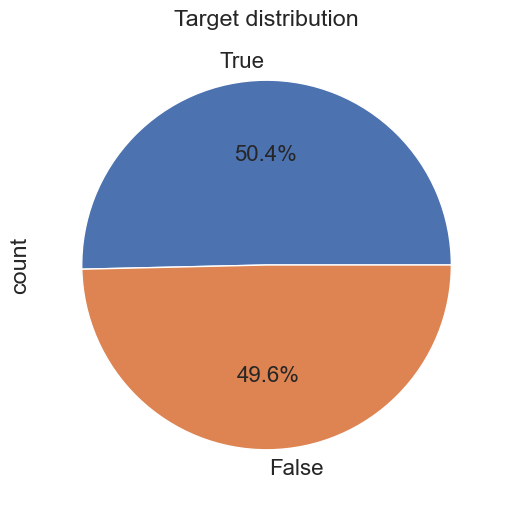

In [238]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot
train_df['Transported'].value_counts().plot.pie(autopct='%1.1f%%', shadow=False, textprops={'fontsize':16}).set_title("Target distribution")

The pie shart shows the target is evenly balanced between true and false.

- determining the number of rows in the train data

In [239]:
len(train_df)

8693

- Analysing the descriptive statistics in the data frame to gain better insights on the numeric variables which makes it easier to understand and use the data accordingly

In [240]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


- Looking at categorical and numeric variables of the data frame

In [241]:
def get_categorical_variables(df):
    return df.select_dtypes(include=['object']).columns

def get_numerical_variables(df):
    return df._get_numeric_data().columns

In [242]:
c_var=get_categorical_variables(train_df)
for col in c_var:
    print(col)

PassengerId
HomePlanet
CryoSleep
Cabin
Destination
VIP
Name


In [243]:
n_var=get_numerical_variables(train_df)
for col in n_var:
    print(col)

Age
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
Transported


## Plot: Distribution of Age by Transported Status

### Description:
- This plot displays the distribution of ages among individuals in the dataset, segmented by their transport status (whether they were transported or not).

### Parameters:
- `train_df`: DataFrame - The DataFrame containing the data.
- `x='Age'`: The variable to be plotted on the x-axis, representing the age of individuals.
- `hue='Transported'`: The variable used for coloring the histogram bars, indicating the transport status of individuals.



### Rationale: 
- By segmenting the age distribution based on the "Transported" status, the plot allows for comparison between individuals who were transported and those who were not. This segmentation can reveal potential differences in age distribution between the two groups. The question to be asked is, "Are certain age groups more likely to be transported than others?" Then if there is some correlation, adding an Age_Group column, will likely increase the accuracy of a model trained on the data.

Text(0.5, 0, 'Age (years)')

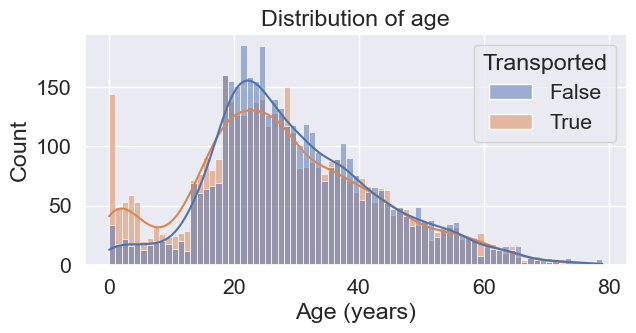

In [244]:
# Figure size
plt.figure(figsize=(7,3))

# Construct Histogram
sns.histplot(data=train_df, x='Age', hue='Transported', binwidth=1, kde=True)

# Plot labels
plt.title('Distribution of age')
plt.xlabel('Age (years)')

### Note: 

There is a correlation between age group and being transported. It appears that younger passengers stand a greater change of being transported, thus this column of age groups can be an important feature to add to a model.

## Plot: Visualization of Credit Spending Features

### Rationale:
- The purpose of this visualization is to explore how passengers allocate their credits across different categories of amenities/services on the spaceship, and to examine potential differences in spending behavior between passengers who were transported and those who were not.


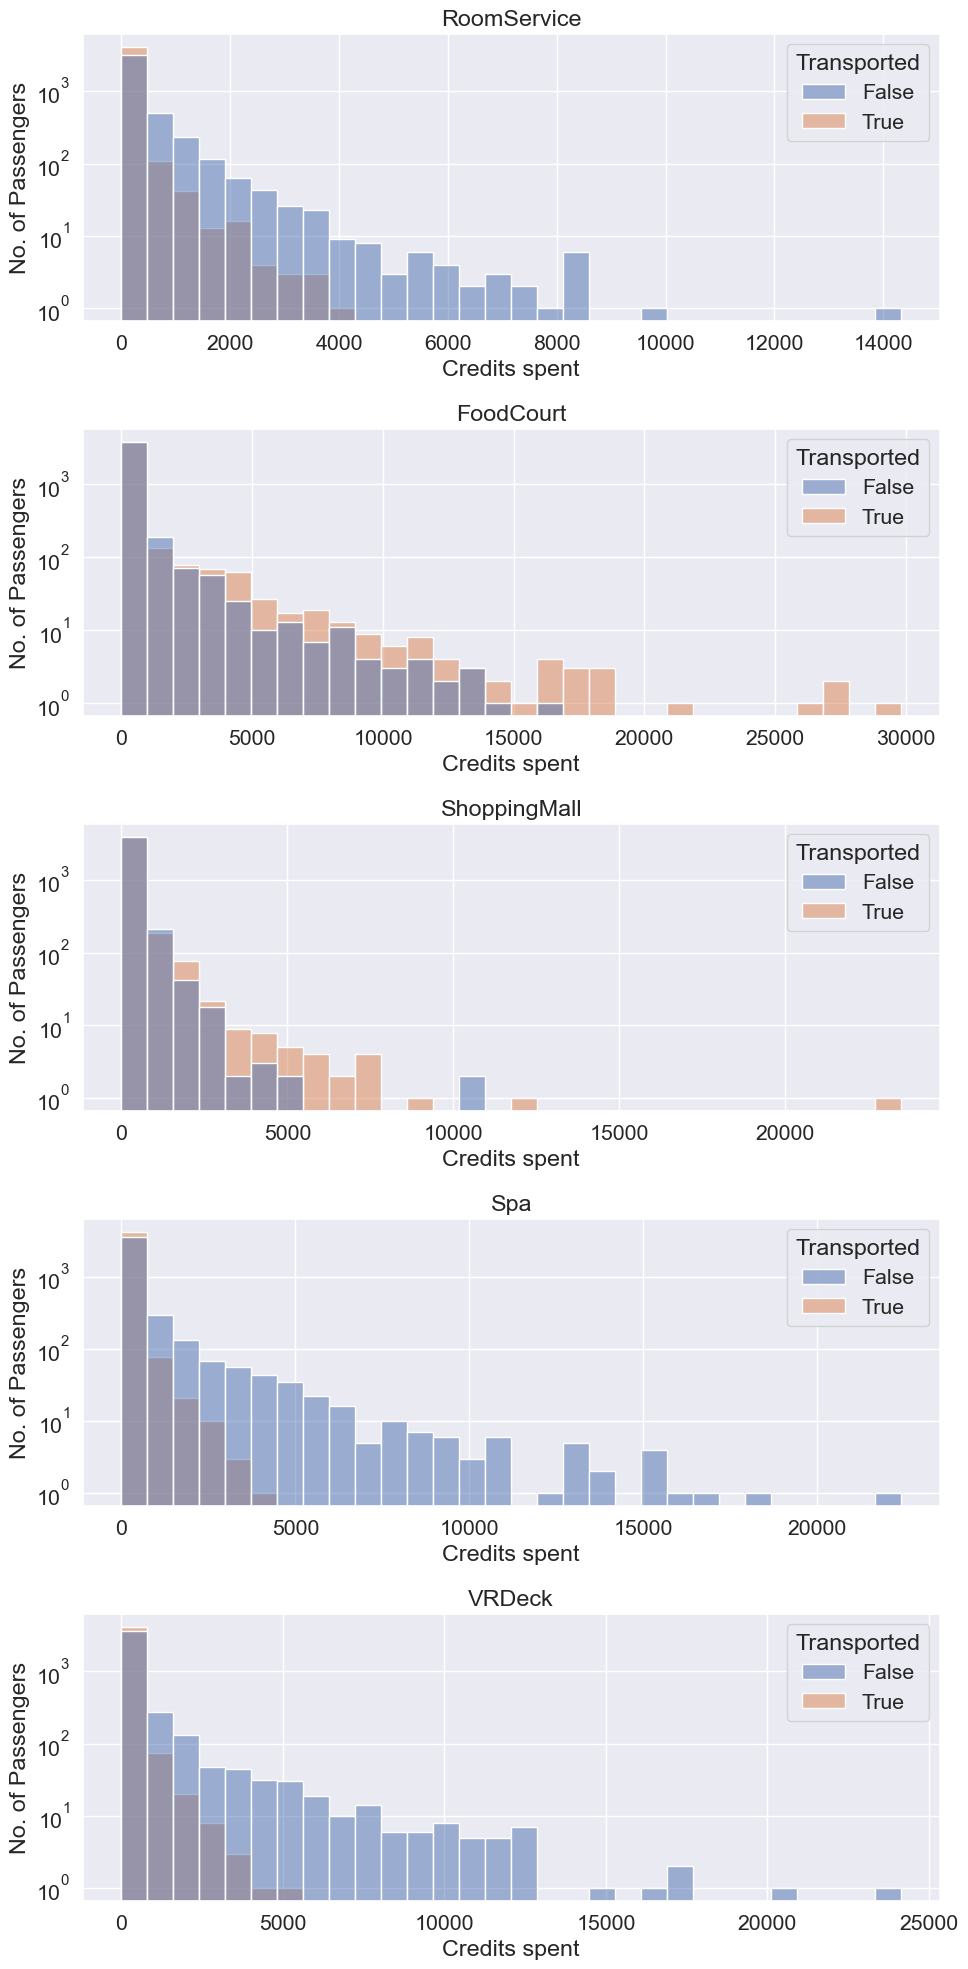

In [245]:
# Credit spending features
total_spent=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(total_spent):
    # Left plot
    ax=fig.add_subplot(5,1,i+1)
    sns.histplot(data=train_df, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    ax.set_yscale('log')  # Setting y-axis to logarithmic scale
    ax.set_xlabel("Credits spent")  
    ax.set_ylabel("No. of Passengers")
    
    
fig.tight_layout()  # Improves appearance a bit
plt.show()

### Note: 
* The histograms of FoodCourt and ShoppingMall look different to that of the other spending features.
* If a passenger was spending more credits in foodcourt and shopping mall it can be assumed that they had quicker access to the escape pad and could escape during an evacuation order.
* Passengers spending credits on VRDeck, Spa, and RoomService, were more likely to not be transported. They may have been receiving room service, in the spa or VR deck during an evacuation order and did not respond as quickly.
* If a passenger spent 0 credits for RoomService, Spa and VRDeck, they were more likely to be saved.
* If a passenger spent 0 credits for FoodCourt and ShoppingMall, they were equally likely to be transported as not.


## Analyse Categorical Features: 
The ratio of passengers transported against not transported across various categorical. The expectation is to observe how each categorical feature may influence whether a passenger is transported or not

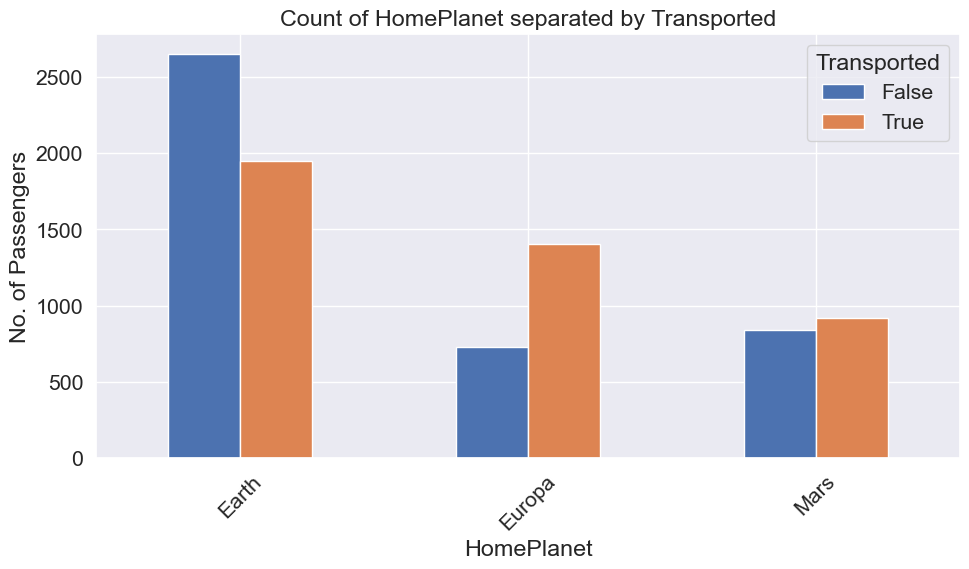

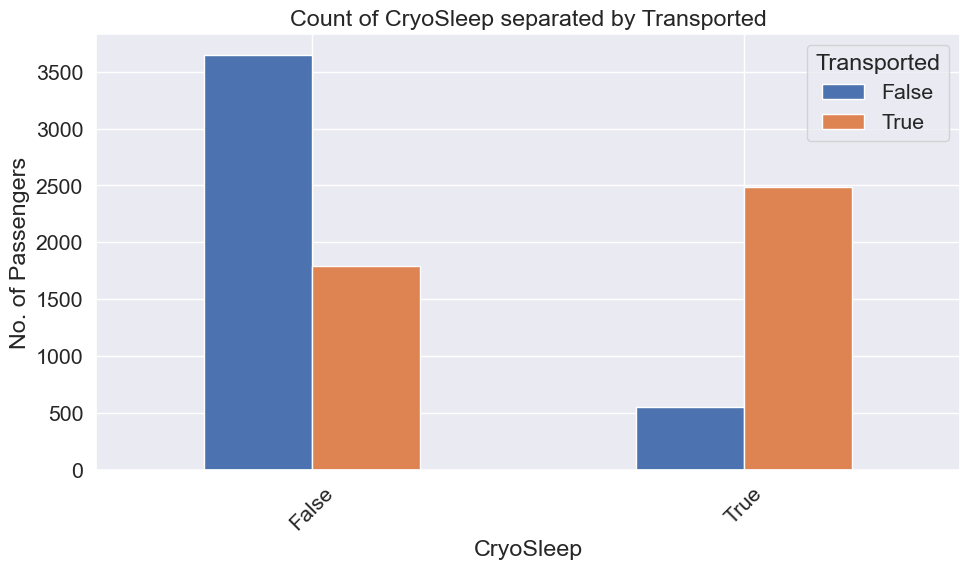

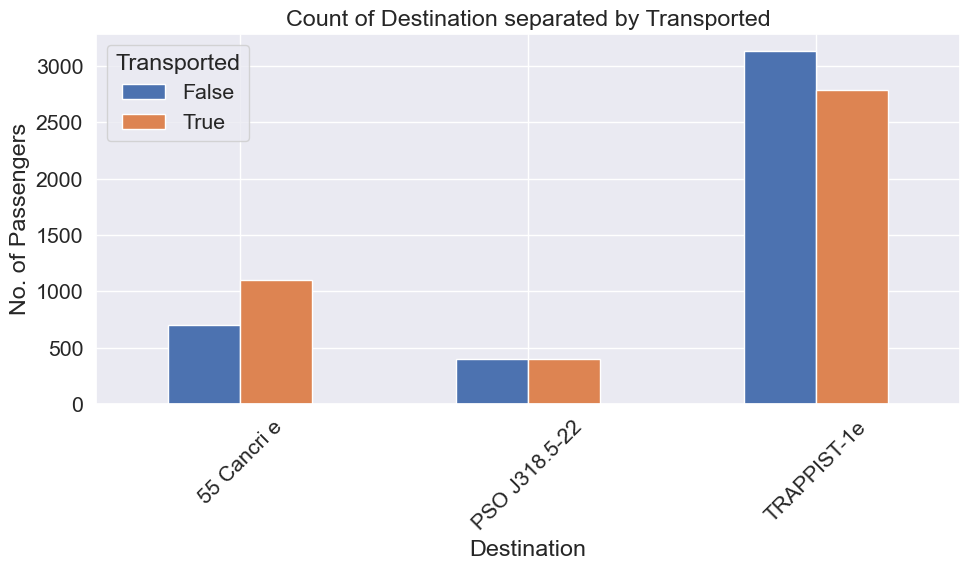

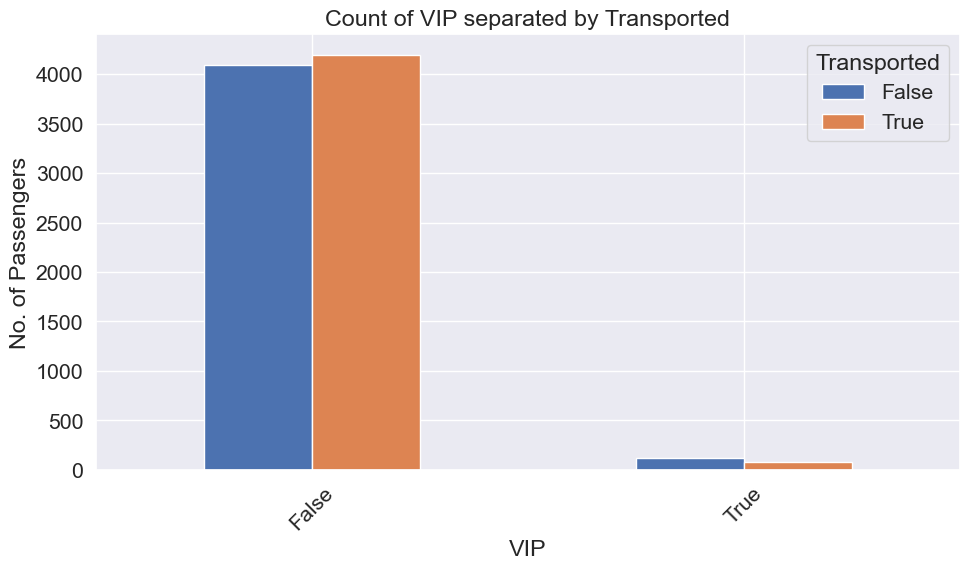

In [246]:
categorial_features=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for i, var in enumerate(categorial_features):
    counts = train_df.groupby([var, 'Transported']).size().unstack()
    counts.plot(kind='bar', stacked=False, figsize=(10, 6))
    plt.title('Count of ' + var +' separated by Transported')
    plt.xlabel(var)
    plt.ylabel('No. of Passengers')
    plt.xticks(rotation=45)
    plt.legend(title='Transported')
    plt.tight_layout()
    plt.show()


### Note: 
The plots show for that transported passengers vary across categorical features. Passengers from Earth as their home planet were less likely to be transported contrary to those passengers that come from Europa. Passengers from Mars are more or less equal in probability of being transported. It seems people who opt for Cryosleep were mostly transported compared to the ones who didn't. The plot of the Destination feature shows that passengers traveling to 55 Cancri e were more likely to be transported than not. Passengers traveling to TRAPPEST-1e were less likely to be transported than not. Also, the VIP's on the spaceship are shown to be more likely to have been transported in contrast to non VIP's.

### Combine the train data and test data 
- This allows for easy cleaning on the whole dataset at once

In [247]:
# Function to combine train and test dataframes
def combine_df(train_df, test_df):
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    return combined_df
def separate_df(combined_df, train_df_len, test_df_len):
    train_df = combined_df.iloc[:train_df_len]
    test_df = combined_df.iloc[train_df_len:train_df_len + test_df_len]
    return train_df, test_df

# Combine train and test dataframes
full_df = combine_df(train_df, test_df)

### Check for duplicates in the dataset
It is possible that there are errors in the dataset, like duplicated whole rows, which should be checked for and corrected, since they could skew the data.

In [248]:
def print_duplicates_info(df):
    num_duplicates = df.duplicated().sum()
    percentage_duplicates = np.round(100 * num_duplicates / len(df), 1)
    print(f'Duplicates in dataset: {num_duplicates}, ({percentage_duplicates}%)')

print_duplicates_info(full_df)

Duplicates in dataset: 0, (0.0%)


### Check for null values in the dataset

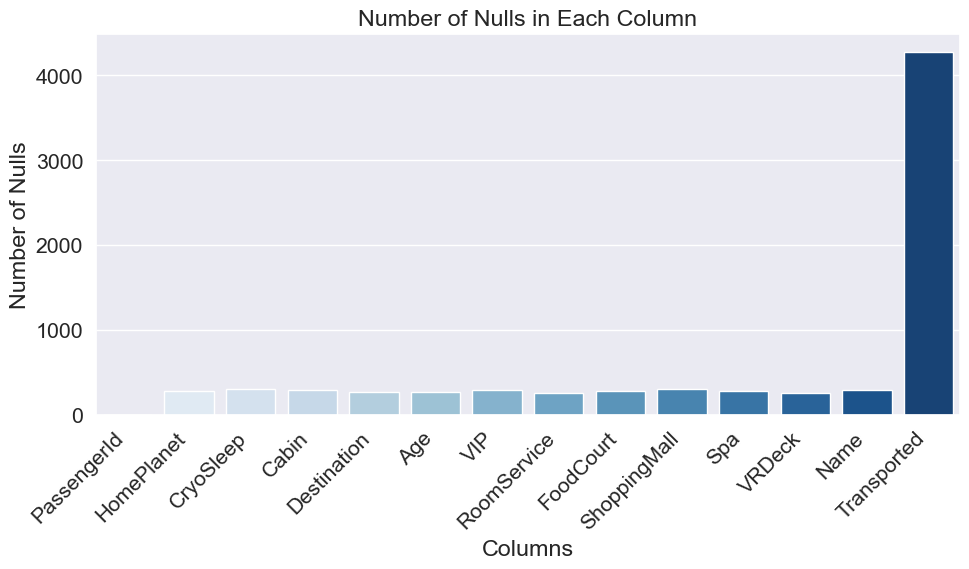

In [249]:
def compute_null_counts(df):
    columns = []
    null_counts = []

    for column in df.columns:
        null_count = df[column].isnull().sum()
        columns.append(column)
        null_counts.append(null_count)

    null_data = pd.DataFrame({'Column': columns, 'Null Count': null_counts})
    return null_data

def plot_null_counts(null_data):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=null_data, x='Column', y='Null Count', palette='Blues')
    plt.xlabel('Columns')
    plt.ylabel('Number of Nulls')
    plt.title('Number of Nulls in Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

null_data = compute_null_counts(full_df)
plot_null_counts(null_data)

### Note: To get a clear comparison, transported column is removed 

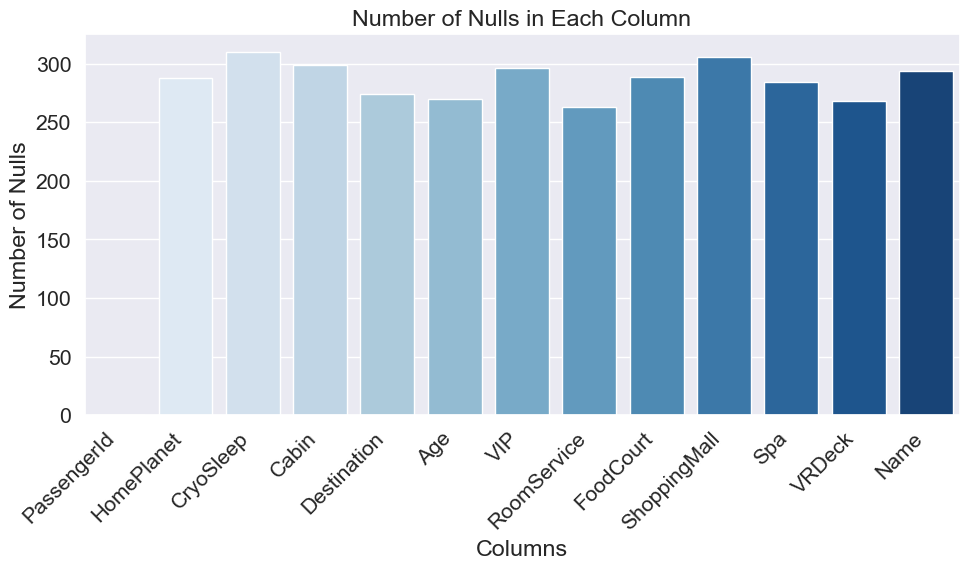

In [250]:
def compute_null_counts_without_transported(df):
    columns = []
    null_counts = []

    for column in df.columns:
        if column != 'Transported':  # Skip the 'Transported' column because we
            null_count = df[column].isnull().sum()
            columns.append(column)
            null_counts.append(null_count)

    null_data = pd.DataFrame({'Column': columns, 'Null Count': null_counts})
    return null_data

null_data_without_transported = compute_null_counts_without_transported(full_df)
plot_null_counts(null_data_without_transported)

### Looking at the null values in the dataset as a percentage
- Computing the percentages of the null values in the data provides insights to the completeness of the dataset.
- The proportion of missing values to the whole data can affect the overall training of the models. The fewer missing values, the more the dataset can be trusted.

In [251]:
def compute_null_percentages(df):
    total_rows = len(df)
    columns = []
    null_percentages = []

    for column in df.columns:
        if column != 'Transported':
            null_count = df[column].isnull().sum()
            null_percentage = (null_count / total_rows) * 100
            columns.append(column)
            null_percentages.append(null_percentage)

    null_percentage_data = pd.DataFrame({'Column': columns, 'Null Percentage': null_percentages})
    return null_percentage_data

null_percentage_data = compute_null_percentages(full_df)
print(null_percentage_data)

          Column  Null Percentage
0    PassengerId         0.000000
1     HomePlanet         2.220509
2      CryoSleep         2.390131
3          Cabin         2.305320
4    Destination         2.112567
5            Age         2.081727
6            VIP         2.282190
7    RoomService         2.027756
8      FoodCourt         2.228219
9   ShoppingMall         2.359291
10           Spa         2.189668
11        VRDeck         2.066307
12          Name         2.266769


# Data Cleaning and Exploration Analysis

## 3 Different approaches on working out Null Values for Different Models

### Rationale:
- Different models achieve different accuracies based on how the data is cleaned.
- The three approaches below show how cleaning of data was considered, by filling in empty data cells and considering outliers.
- Based on numerous tests in this project, specific models used different cleaning approaches which gave higher accuracies

### Creating different data frames on which to peform different cleaning techniques.
Four engineers created four different data frames, but the only applicable differences were found in two datasets, which are attributed to Aidan and Ernest, so these two are tested on the models, along with a control group. The Aidan and Ernest dataframes include specific techniques which were though about logically and tested in their research. This includes considering outliers in age; analysing trends in home planets; using K-Nearest Neighbours (KNN) to fill values, etc. The control dataframe, dfControl, is simply fit to run on models with minimal intervention, i.e. the naN values are filled with the mean values for that column, and any shaping of the data for it to fit certain models is done, e.g. converting categorical or Boolean values to numerical where needed.

In [281]:
dfControl=full_df
dfAidan=full_df
dfErnest=full_df


## Approach 1 - Filling empty cells using mean and mode.

This function fills null values in categorical variables of a DataFrame with the mode of each column.

### Parameters:
- `df`: DataFrame: The DataFrame containing categorical variables with null values.
- `categorical_variables`: list: List of categorical variable names.
- `numerical_variables`: list: List of numerical variable names.

Categorical data, like string datatypes, and numerical data, like integers, are handled differently by different models, so this function organizes the data into both.


In [282]:
def filling_null_categorical_vars_with_mode(df,categorical_variables):
    for cat_col in categorical_variables:
        if cat_col!="Name":
            df[cat_col] = df[cat_col].fillna(df[cat_col].mode()[0])

def filling_null_numerical_vars_with_mean(df, numerical_variables):
    for num_col in numerical_variables:
        df[num_col] = df[num_col].fillna(df[num_col].mean())
        


## Splitting the Name column into First and Last; Splitting the Cabin into its Constituents

### Also, outliers in the age category are removed


In [283]:
# Define the function to calculate family size
def calculate_family_size(df):
    df[['FirstName', 'LastName']] = df['Name'].str.split(expand=True)
    cabin_split = df['Cabin'].str.split('/', expand=True)
    cabin_split.columns = ['Deck', 'Room_Number', 'Side']
    df = pd.concat([df, cabin_split], axis=1)
    df.drop(columns=['Cabin', 'Name'], inplace=True)
    
    family_counts = df.groupby(['LastName', 'Room_Number'])['LastName'].transform('count')
    df['FamilySize'] = family_counts
    
    return df

# Define the function to remove outliers from the 'Age' column
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with the mean value of the column
    df.loc[df[column] < lower_bound, column] = df[column].mean()
    df.loc[df[column] > upper_bound, column] = df[column].mean()
    
    return df

# Call the function to calculate family size
dfAidan = calculate_family_size(dfAidan)

# Calculate the mean age before removing outliers
mean_age_outliers = dfAidan['Age'].mean()

# Replace outliers with the mean age
dfAidan = remove_outliers(dfAidan, 'Age')

# Calculate the mean age after removing outliers
mean_age = dfAidan['Age'].mean()

# Print the mean age
print("Mean Age (before removing outliers):", mean_age_outliers)
print("Mean Age (after removing outliers):", mean_age)

Mean Age (before removing outliers): 28.771968503937007
Mean Age (after removing outliers): 28.404402876805754


### Note: The difference in mean age without outlier was not that significant, but going forward mean age after removing the outliers was used. Outliers were removed because it was identified that only a few ages were outlying, and assessed that this could skew the data.

# Feature Engineering
## Creating additional features in the data set

### Rationale: This function enhances the dataset by providing more insights into the passengers' age distribution and family survival rates, which could be valuable for predictive modeling and analysis.

In [284]:
dfAidan

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FirstName,LastName,Deck,Room_Number,Side,FamilySize
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Maham,Ofracculy,B,0,P,1.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Juanna,Vines,F,0,S,1.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Altark,Susent,A,0,S,2.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Solam,Susent,A,0,S,2.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Willy,Santantines,F,1,S,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,NaN,Jeron,Peter,G,1496,S,1.0
12966,9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,NaN,Matty,Scheron,NaN,NaN,NaN,NaN
12967,9271_01,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,NaN,Jayrin,Pore,D,296,P,1.0
12968,9273_01,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,NaN,Kitakan,Conale,D,297,P,1.0


In [285]:
# Creating interaction features and adding more features
def create_interaction_features(df):
    # Age group
    df['Age_Group'] = pd.cut(df['Age'], bins=[0, 15, 30, 45, 60, 75, 90, 105], labels=['Child', 'Young Adult', 'MiddleAge', 'Adult', 'OldAdult', 'Elderly', 'Oldest'])

    # Count of family members (assuming 'LastName' and 'Room_Number' are available)
    df['FamilyCount'] = df.groupby(['LastName', 'Room_Number'])['PassengerId'].transform('count')

    return df

# Create interaction features and additional features
dfAidan = create_interaction_features(dfAidan)

# Display the updated dataframe
dfAidan.head()


,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,FirstName,LastName,Deck,Room_Number,Side,FamilySize,Age_Group,FamilyCount
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Maham,Ofracculy,B,0,P,1.0,MiddleAge,1.0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Juanna,Vines,F,0,S,1.0,Young Adult,1.0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Altark,Susent,A,0,S,2.0,Adult,2.0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Solam,Susent,A,0,S,2.0,MiddleAge,2.0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Willy,Santantines,F,1,S,1.0,Young Adult,1.0


The figure below shows that the age groups are in fact relevant, with younger groups standing a greater chance of being transported. This logically makes sense, due to the "Children first" saying which often occurs in disasters.

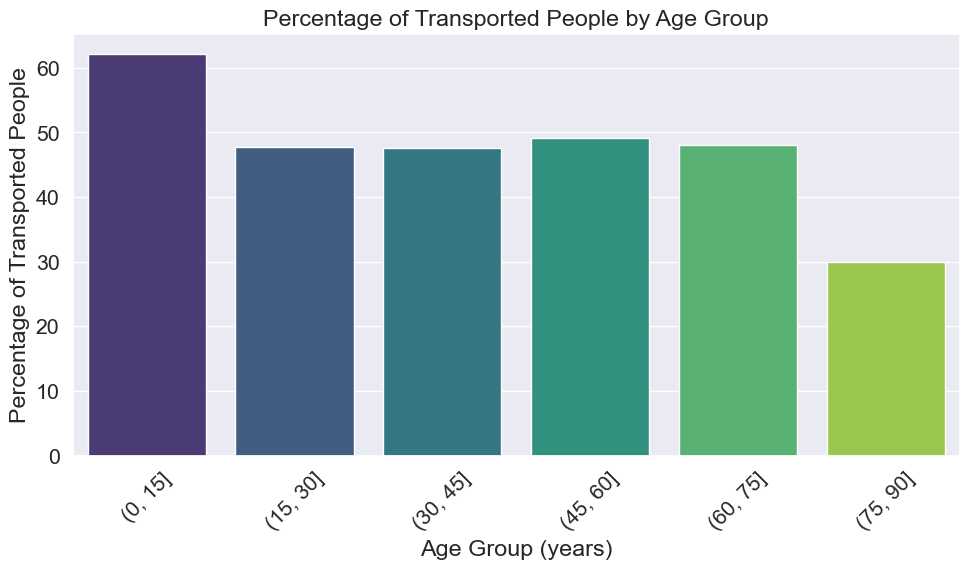

In [286]:
# Bin ages into intervals of 15 years
age_bins = np.arange(0, 105, 15)
train_df['AgeGroup'] = pd.cut(train_df['Age'], bins=age_bins)

# Calculate percentage of people transported in each age group
transported_percentage = train_df.groupby('AgeGroup')['Transported'].mean() * 100

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=transported_percentage.index.astype(str), y=transported_percentage.values, palette='viridis')

# Plot labels
plt.title('Percentage of Transported People by Age Group')
plt.xlabel('Age Group (years)')
plt.ylabel('Percentage of Transported People')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Approach 2 - Filling nulls with KNNImputer and OneHotEncoder

The filling_nulls_using_KNNImputer_and_OneHotEncoder function is designed to handle missing values in a DataFrame by applying the KNNImputer for numeric columns and OneHotEncoder for categorical columns. It ensures that the DataFrame is returned with all missing values filled and categorical features encoded, ready for further analysis.

In [287]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

def filling_nulls_using_KNNImputer_and_OneHotEncoder(df):
    # Identify columns with missing values
    columns_with_missing = df.columns[df.isnull().any()]
    
    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = list(set(columns_with_missing) - set(numeric_cols))
    
    # Apply one-hot encoding to categorical columns
    if categorical_cols:
        df_categorical = df[categorical_cols]
        encoder = OneHotEncoder(drop='if_binary')
        df_categorical_encoded = pd.DataFrame(encoder.fit_transform(df_categorical).toarray())
        df_categorical_encoded.columns = encoder.get_feature_names_out(categorical_cols)
    
    # Fill missing values in numeric columns using KNNImputer
    if len(numeric_cols) != 0:  # Check if numeric_cols is not empty
        imputer = KNNImputer()
        df_numeric = df[numeric_cols]
        df_numeric_filled = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)
    
    # Merge filled numeric columns with one-hot encoded categorical columns
    if len(numeric_cols) != 0 and len(categorical_cols) != 0:
        df = pd.concat([df_numeric_filled, df_categorical_encoded], axis=1)
    elif len(categorical_cols) != 0:
        df = df_categorical_encoded
    elif len(numeric_cols) != 0:
        df = df_numeric_filled
    
    return df

filling_nulls_using_KNNImputer_and_OneHotEncoder(dfAidan)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,FamilySize,FamilyCount,Destination_55 Cancri e,Destination_PSO J318.5-22,...,LastName_Wriggins,LastName_Wynneyerson,LastName_Yanton,LastName_Yatters,LastName_Yorkland,LastName_Youngrayes,LastName_nan,Side_P,Side_S,Side_nan
0,39.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,16.0,303.0,70.0,151.0,565.0,2.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,34.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12966,42.0,0.0,847.0,17.0,10.0,144.0,1.4,1.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12967,25.4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12968,30.4,0.0,2680.0,0.0,0.0,523.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Data cleaning approach 3

Below is the data exploration and cleaning from dfErnest. This is a much more complicated and in-depth approach to analysing the data, which permeates through each column, individually thinking about how each column could be engineered. In the self-learning section near the end of this report, the accuracy differences between taking a complicated approach like assessing each column, and taking a simple approach, like taking the average values for each column to fill in naN values, are assessed. Interestingly, it is found that the simple approach provides a higher accuracy, which speaks to Occam's Razor in Machine Learning and how simple models may have better understandings of complex data [1].

### Filling Null values column by column

- This approach takes an in depth analysis of the missing data and how they relate with other factors
- By cleaning the data column by column offers a greater opportunity of having a good training data


### Filling Null Values in the HomePlanet Column
- We are using the relationship between the Destination and the planet an individual came form

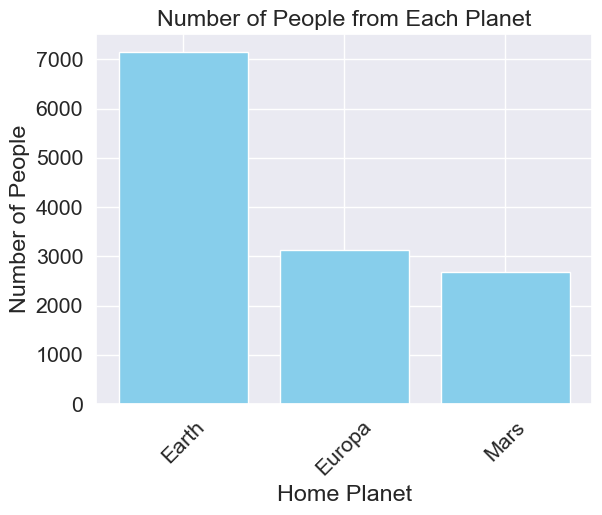

In [288]:
# Create a DataFrame with the count of people from each planet
planet_counts = dfErnest['HomePlanet'].value_counts()

# Plotting
plt.bar(planet_counts.index, planet_counts.values, color='skyblue')
plt.title('Number of People from Each Planet')
plt.xlabel('Home Planet')
plt.ylabel('Number of People')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

- To see how many possible destinations we have:

In [289]:
print("Number of unique destinations:", dfErnest['Destination'].nunique())


Number of unique destinations: 3


- To see the count of people going to each unique Destination

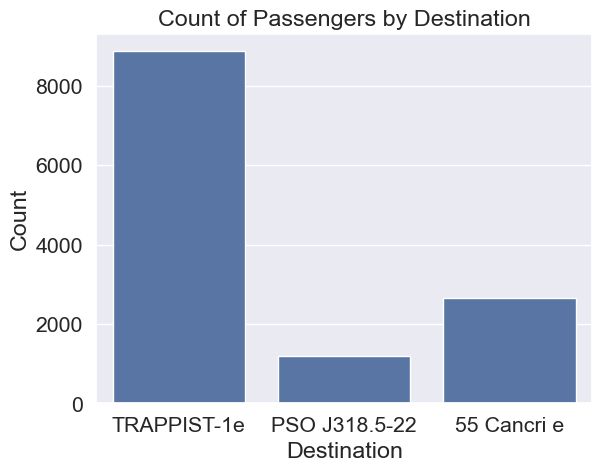

In [290]:
sb.countplot(data=dfErnest, x='Destination')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Count of Passengers by Destination')
plt.show()

### Note: It is clear that more people are going to TRAPPIST-1e, 55 Cancri-e and PSO J318.5-22 respectively

- For each destination, how many people from each planet are going there:

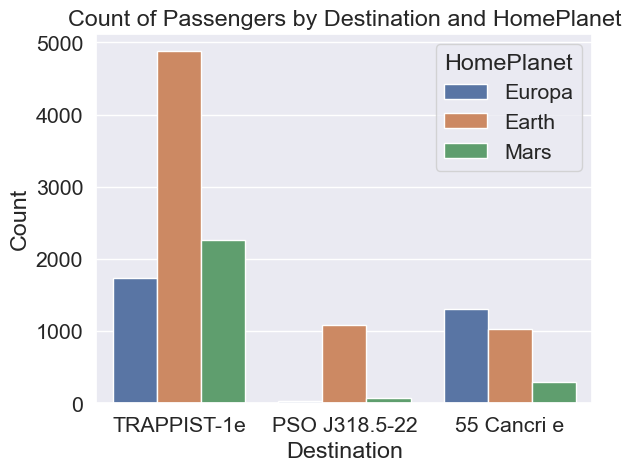

In [291]:

sb.countplot(data=dfErnest, x='Destination', hue='HomePlanet')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Count of Passengers by Destination and HomePlanet')
plt.legend(title='HomePlanet')
plt.show()

- How many people from each planet are VIP or not:

- Group by both HomePlanet and VIP, then count the occurrences

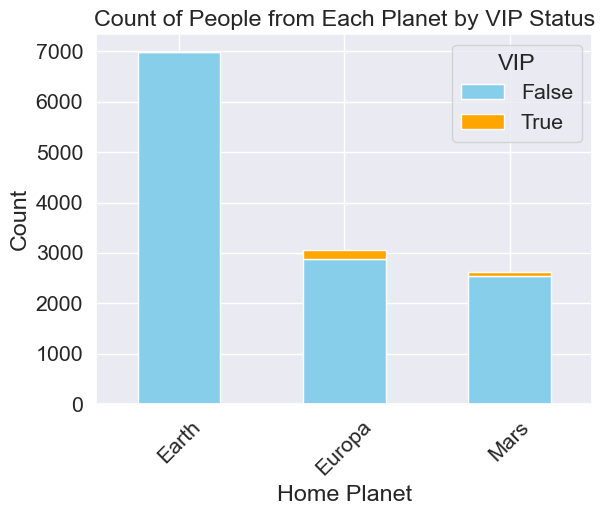

In [292]:
planet_vip_counts = dfErnest.groupby(['HomePlanet', 'VIP']).size().unstack(fill_value=0)

# Plotting
planet_vip_counts.plot(kind='bar', stacked=True, color=['skyblue', 'orange'])
plt.title('Count of People from Each Planet by VIP Status')
plt.xlabel('Home Planet')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='VIP')
plt.show()

- Age distribution of People from each Planet:

In [293]:
grouped = dfErnest.groupby('HomePlanet')['Age']

# Calculate quartiles
quartiles = grouped.describe(percentiles=[0.25, 0.5, 0.75])

# Print quartiles in words
for planet, data in quartiles.iterrows():
    print(f"HomePlanet: {planet}")
    print(f"25th Percentile (Q1): {data['25%']:.2f} years")
    print(f"Median (Q2): {data['50%']:.2f} years")
    print(f"75th Percentile (Q3): {data['75%']:.2f} years")
    print("")


HomePlanet: Earth
25th Percentile (Q1): 18.00 years
Median (Q2): 23.00 years
75th Percentile (Q3): 35.00 years

HomePlanet: Europa
25th Percentile (Q1): 26.00 years
Median (Q2): 33.00 years
75th Percentile (Q3): 42.00 years

HomePlanet: Mars
25th Percentile (Q1): 20.00 years
Median (Q2): 28.00 years
75th Percentile (Q3): 38.00 years



### Note: This probability distribution should still stand even after the imputation.

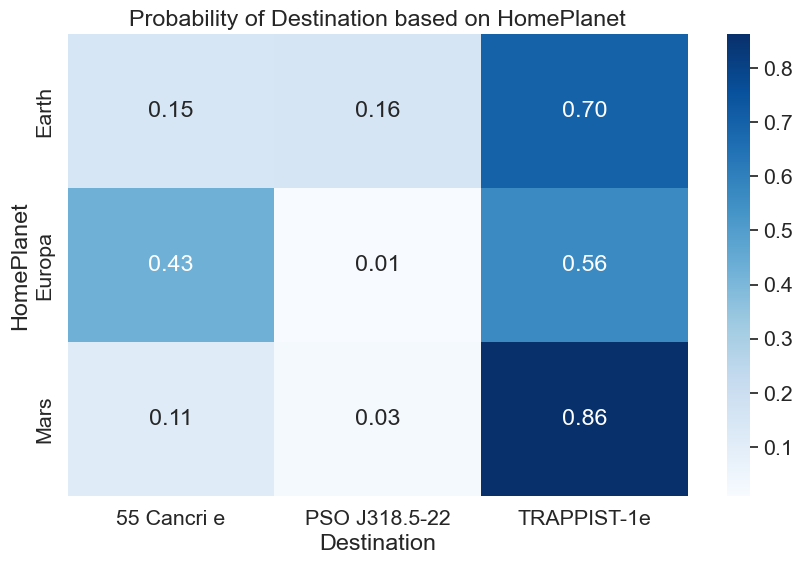

In [294]:
# Count occurrences of each combination of HomePlanet and Destination
counts = dfErnest.groupby(['HomePlanet', 'Destination']).size().unstack(fill_value=0)

# Normalize the counts to get probabilities
probabilities = counts.div(counts.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sb.heatmap(probabilities, annot=True, cmap='Blues', fmt=".2f", cbar=True)
plt.title('Probability of Destination based on HomePlanet')
plt.xlabel('Destination')
plt.ylabel('HomePlanet')
plt.show()

- Check the number of null values in the HomePlanet column

In [295]:
null_count = dfErnest['HomePlanet'].isnull().sum()
print("Number of null values in HomePlanet column:", null_count)

Number of null values in HomePlanet column: 0


- Attempts to Imputate all null values in HomePlanet based on stats

In [392]:
# Function to impute null values in HomePlanet column based on Destination and VIP status
def fill_null_homeplanet(df):
    for index, row in df.iterrows():
        if pd.isnull(row['HomePlanet']):
            if row['Destination'] == 'TRAPPIS-1e' and row['VIP']:
                age = row['Age']
                if age < 26:
                    df.at[index, 'HomePlanet'] = 'Europa'
                else:
                    df.at[index, 'HomePlanet'] = 'Mars'
            elif row['Destination'] == 'PSO J318.5-22':
                df.at[index, 'HomePlanet'] = 'Earth'
            elif row['Destination'] == '55 Cancri e' and not row['VIP']:
                df.at[index, 'HomePlanet'] = 'Earth'
            elif row['Destination'] == '55 Cancri e' and row['VIP']:
                df.at[index, 'HomePlanet'] = 'Europa'
            else:
                df.at[index, 'HomePlanet'] = 'Earth'
    return df

# Apply the function to impute null values in the HomePlanet column
dfErnest = fill_null_homeplanet(dfErnest)



- Check the number of null values in the HomePlanet column

In [297]:
null_count = dfErnest['HomePlanet'].isnull().sum()
print("Number of null values in HomePlanet column:", null_count)


Number of null values in HomePlanet column: 0


### Check if probability distribution remained unchanged.

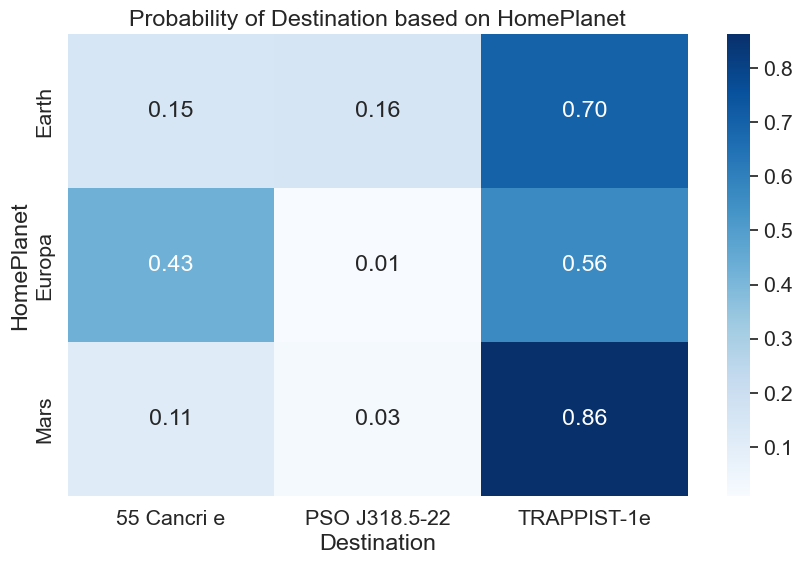

In [298]:
# Count occurrences of each combination of HomePlanet and Destination
counts = dfErnest.groupby(['HomePlanet', 'Destination']).size().unstack(fill_value=0)

# Normalize the counts to get probabilities
probabilities = counts.div(counts.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sb.heatmap(probabilities, annot=True, cmap='Blues', fmt=".2f", cbar=True)
plt.title('Probability of Destination based on HomePlanet')
plt.xlabel('Destination')
plt.ylabel('HomePlanet')
plt.show()

### Filling Null Values in the CryoSleep Column:



- Relate the CryoSleep with Expenditures

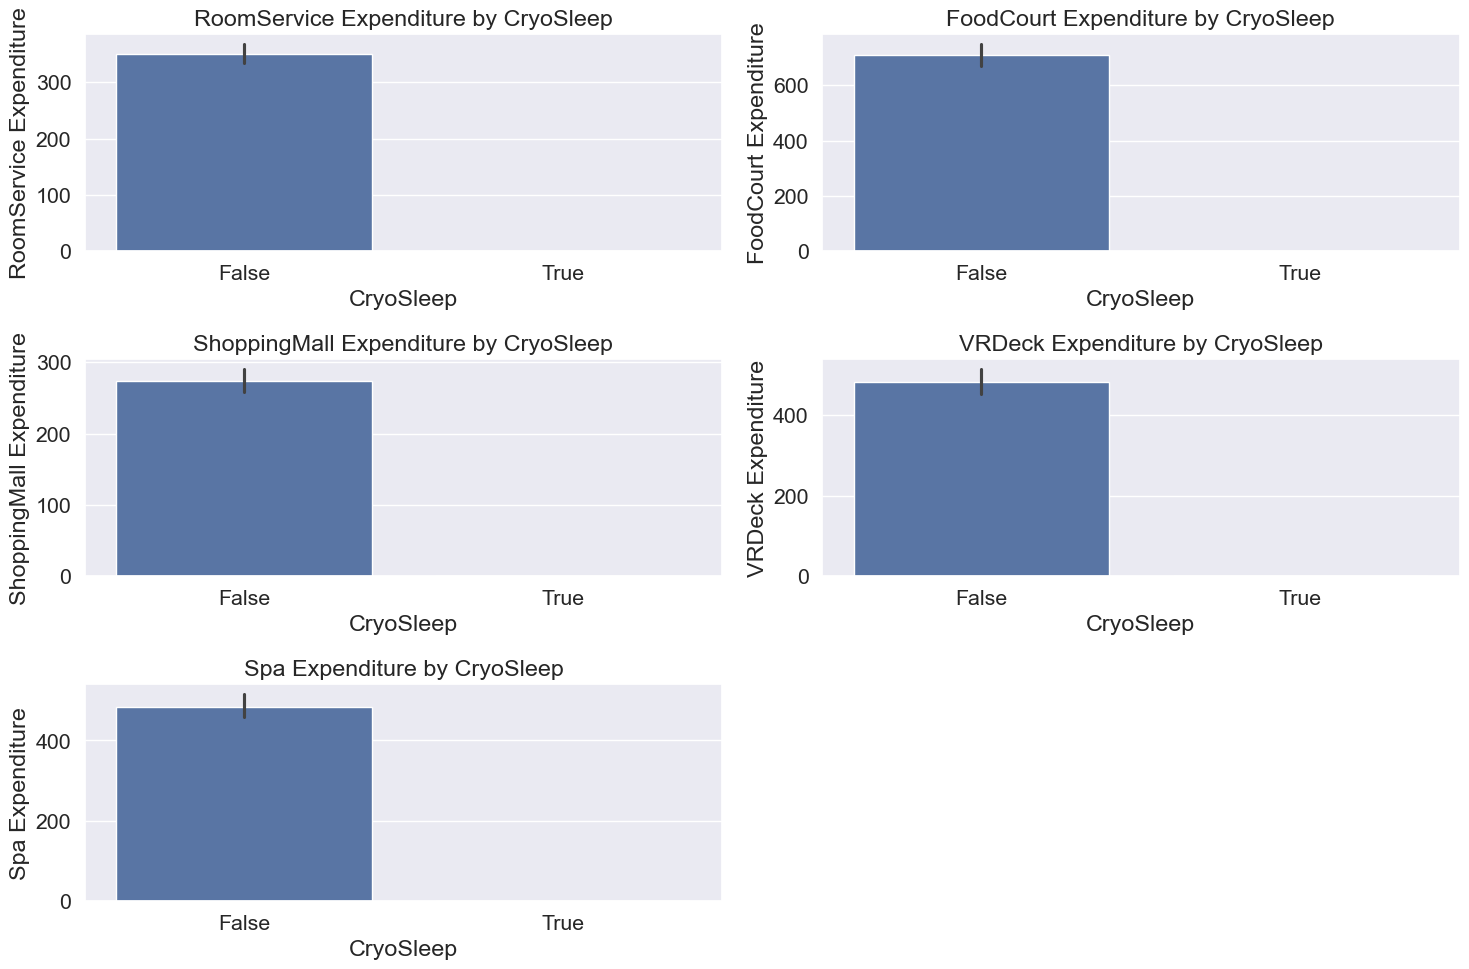

In [299]:
# List of columns
columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck', 'Spa']

# Plotting
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns):
    plt.subplot(3, 2, i+1)  # Adjusted indexing
    sb.barplot(x='CryoSleep', y=col, data=dfErnest)
    plt.title(f'{col} Expenditure by CryoSleep')
    plt.xlabel('CryoSleep')
    plt.ylabel(f'{col} Expenditure')
plt.tight_layout()
plt.show()


### Note: We see that When CryoSleep is True, all expenditures are Zero:

In [301]:
# Fill null values in CryoSleep based on the sum of expenditures
def fill_null_cryosleep(df):
    df['CryoSleep'] = df['CryoSleep'].fillna((df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['VRDeck']) == 0)
    return df

dfErnest = fill_null_cryosleep(dfErnest)
null_count = dfErnest['CryoSleep'].isnull().sum()
print("Number of null values in CryoSleep column:", null_count)

Number of null values in CryoSleep column: 0


### Filling Null values for the Cabin Number:

In [302]:
nulls_in_name = dfErnest['Cabin'].isnull().sum()
print("Number of null values in the Cabin column:", nulls_in_name)

Number of null values in the Cabin column: 299


In [303]:
nulls_in_name = dfErnest['Name'].isnull().sum()
print("Number of null values in the Name column:", nulls_in_name)

Number of null values in the Name column: 294


In [304]:
# Count the number of null values in Cabin corresponding to null values in Name
null_cabin_null_name_count = dfErnest[dfErnest['Cabin'].isnull() & dfErnest['Name'].isnull()].shape[0]

print("Number of null values in Cabin corresponding to null values in Name:", null_cabin_null_name_count)


Number of null values in Cabin corresponding to null values in Name: 3


In [305]:
# Initialize a counter for group numbers with no other rows having a non-null Cabin number
count_unique_group_numbers = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Extract group number from PassengerId
    group_number = row['PassengerId'].split('_')[0]
    
    # Check if there are other rows with the same group number and a non-null Cabin number
    if dfErnest[(dfErnest['PassengerId'].str.split('_').str[0] == group_number) & (~dfErnest['Cabin'].isnull())].empty:
        count_unique_group_numbers += 1

print("Number of group numbers with no other rows having a non-null Cabin number:", count_unique_group_numbers)

Number of group numbers with no other rows having a non-null Cabin number: 162


In [390]:
def fill_null_cabin_by_group(df):
    # Extract group numbers from PassengerId for rows with null Cabin values
    null_cabin_groups = df[df['Cabin'].isnull()]['PassengerId'].str.split('_').str[0]
    
    # Iterate over each null Cabin row
    for index, row in df[df['Cabin'].isnull()].iterrows():
        # Get the group number for the current row
        group_number = row['PassengerId'].split('_')[0]
        
        # Find other rows with the same group number and non-null Cabin values
        similar_group_rows = df[(df['PassengerId'].str.split('_').str[0] == group_number) & (~df['Cabin'].isnull())]
        
        # If there are similar group rows, fill the null Cabin value with the first non-null Cabin value
        if not similar_group_rows.empty:
            df.at[index, 'Cabin'] = similar_group_rows.iloc[0]['Cabin']
    
    return df

# Apply the fill_null_cabin function
dfErnest = fill_null_cabin_by_group(dfErnest)


### Rationale
For every null value in the Cabin column, i want check the corresponding group number(gggg) in the PassengerId column. Then check if there are any other similiar group numbers(gggg) in the PassengerId column with the non-null corresponding values in Cabin column. If so, give that null value the same Cabin value as those having the same group number

In [307]:
nulls_in_name = dfErnest['Cabin'].isnull().sum()
print("Number of null values in the Cabin column:", nulls_in_name)

Number of null values in the Cabin column: 162


In [308]:
# Count the number of null values in Cabin corresponding to null values in Name
null_cabin_null_name_count = dfErnest[dfErnest['Cabin'].isnull() & dfErnest['Name'].isnull()].shape[0]

print("Number of null values in Cabin corresponding to null values in Name:", null_cabin_null_name_count)

Number of null values in Cabin corresponding to null values in Name: 1


In [309]:
# Initialize a counter for unique last names with no other rows having a non-null Cabin number
count_unique_last_names = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Check if the 'Name' column is not null
    if not pd.isnull(row['Name']):
        # Extract the last name from the Name column
        last_name = row['Name'].split()[-1]
    
    # Check if there are other rows with the same last name and a non-null Cabin number
    if dfErnest[(dfErnest['Name'].str.split().str[-1] == last_name) & (~dfErnest['Cabin'].isnull())].empty:
        count_unique_last_names += 1
    
print("Number of unique last names with no other rows having a non-null Cabin number:", count_unique_last_names)

Number of unique last names with no other rows having a non-null Cabin number: 4


### Rationale
This code iterates over each row with a null value in the Cabin column, extracts the last name from the corresponding Name column,finds other rows with the same last name and a non-null Cabin number, and fills in the null value in the Cabin column with the found Cabin number.

In [314]:
def fill_null_cabin_by_name(df):
    # Iterate over each row with a null value in the Cabin number column
    for index, row in df[df['Cabin'].isnull()].iterrows():
        # Check if the 'Name' column is not null
        if not pd.isnull(row['Name']):
            # Extract the last name from the Name column
            last_name = row['Name'].split()[-1]
        
        # Find other rows with the same last name and a non-null Cabin number
        matching_rows = df[(df['Name'].str.split().str[-1] == last_name) & (~df['Cabin'].isnull())]
        
        # Check if there are any matching rows
        if not matching_rows.empty:
            # Get the Cabin number from the first matching row
            cabin_number = matching_rows.iloc[0]['Cabin']
            
            # Fill in the null value in the Cabin column with the found Cabin number
            df.at[index, 'Cabin'] = cabin_number
    return df

dfErnest = fill_null_cabin_by_name(dfErnest)

In [315]:
nulls_in_name = dfErnest['Cabin'].isnull().sum()
print("Number of null values in the Cabin column:", nulls_in_name)

Number of null values in the Cabin column: 4


### Fill nulls in Name feature

The first approach is to fill in nulls in Name with a passengers last name according to a member within their cabin.

In [ ]:
nulls_in_name = dfErnest['Name'].isnull().sum()
print("Number of null values in the Name column:", nulls_in_name)

Number of null values in the Name column: 294


In [317]:
def fill_null_name_by_cabin(df):
    # Iterate over each row with a null value in the Name column
    for index, row in df[df['Name'].isnull()].iterrows():
        # Extract the Cabin number from the corresponding Cabin column
        cabin_number = row['Cabin']
        
        # Find other rows with the same Cabin number and a non-null Name
        matching_rows = df[(df['Cabin'] == cabin_number) & (~df['Name'].isnull())]
        
        # Check if there are any matching rows
        if not matching_rows.empty:
            # Get the first matching row
            matching_row = matching_rows.iloc[0]
            
            # Extract the last name from the non-null Name value
            last_name = matching_row['Name'].split()[-1]
            
            # Fill in the null value in the Name column with the generated name
            df.at[index, 'Name'] = "[Firstname]" + last_name
    return df

dfErnest = fill_null_name_by_cabin(dfErnest)

nulls_in_name = dfErnest['Name'].isnull().sum()
print("Number of null values in the Name column:", nulls_in_name)

Number of null values in the Name column: 179


The next approach is to fill in names according to the passengers group

In [319]:
def fill_null_name_by_group(df):
    # Iterate over each row with a null value in the Name column
    for index, row in df[df['Name'].isnull()].iterrows():
        # Extract the group number (gggg) from the corresponding PassengerId column
        group_number = row['PassengerId'].split('_')[0]
        
        # Find other rows with the same group number and a non-null Name
        matching_rows = df[(df['PassengerId'].str.split('_').str[0] == group_number) & (~df['Name'].isnull())]
        
        # Check if there are any matching rows
        if not matching_rows.empty:
            # Get the first matching row
            matching_row = matching_rows.iloc[0]
            
            # Extract the last name from the non-null Name value
            last_name = matching_row['Name'].split()[-1]
            
            # Fill in the null value in the Name column with the generated name
            df.at[index, 'Name'] = "Firstname A " + last_name
    return df

dfErnest = fill_null_name_by_group(dfErnest)


nulls_in_name = dfErnest['Name'].isnull().sum()
print("Number of null values in the Name column:", nulls_in_name)

Number of null values in the Name column: 154


The cabin feature is now further explored to see if any relations exist between missing values and other features.

In [321]:
# Initialize a counter for unique last names with no other rows having a non-null Cabin number
count_unique_last_names = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Check if the 'Name' column is not null
    if not pd.isnull(row['Name']):
        # Extract the last name from the Name column
        last_name = row['Name'].split()[-1]
    
    # Check if there are other rows with the same last name and a non-null Cabin number
    if dfErnest[(dfErnest['Name'].str.split().str[-1] == last_name) & (~dfErnest['Cabin'].isnull())].empty:
        count_unique_last_names += 1

print("Number of unique last names with no other rows having a non-null Cabin number:", count_unique_last_names)

Number of unique last names with no other rows having a non-null Cabin number: 4


In [322]:
# Initialize a counter for group numbers with no other rows having a non-null Cabin number
count_unique_group_numbers = 0

# Iterate over each row with a null value in the Cabin number column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Extract group number from PassengerId
    group_number = row['PassengerId'].split('_')[0]
    
    # Check if there are other rows with the same group number and a non-null Cabin number
    if dfErnest[(dfErnest['PassengerId'].str.split('_').str[0] == group_number) & (~dfErnest['Cabin'].isnull())].empty:
        count_unique_group_numbers += 1

print("Number of group numbers with no other rows having a non-null Cabin number:", count_unique_group_numbers)

Number of group numbers with no other rows having a non-null Cabin number: 4


In [323]:
# Iterate over each row with a null value in the Cabin column
for index, row in dfErnest[dfErnest['Cabin'].isnull()].iterrows():
    # Print the PassengerId and Name for the current row
    print("PassengerId:", row['PassengerId'], "Name:", row['Name'])

PassengerId: 0502_01 Name: Pigars Swell
PassengerId: 2117_01 Name: Azet Rocketedy
PassengerId: 3553_01 Name: Wafox Maie
PassengerId: 6385_01 Name: Possh Duncy


In [326]:
mode_cabin = dfErnest['Cabin'].mode().iloc[0]  # Mode of the 'Cabin' column in the row
print("Mode of 'Cabin' for row at index", index, ":", mode_cabin)

Mode of 'Cabin' for row at index 6037 : F/1194/P


Fill remaining Null values for cabin with mode. This is an imperfect method but since it is only 4 passengers that need to be filled, it won't affect the integrity of the dataset too much

In [329]:
def fill_null_cabin_by_mode(df):
    # Calculate the mode of the 'Cabin' column
    mode_cabin = df['Cabin'].mode().iloc[0]

    # Fill null values in the 'Cabin' column with the mode
    df['Cabin'].fillna(mode_cabin, inplace=True)
    return df

dfErnest = fill_null_cabin_by_mode(dfErnest)

In [331]:
nulls_in_name = dfErnest['Cabin'].isnull().sum()
print("Number of null values in the Cabin column:", nulls_in_name)

Number of null values in the Cabin column: 0


### Filling Null values in VIP

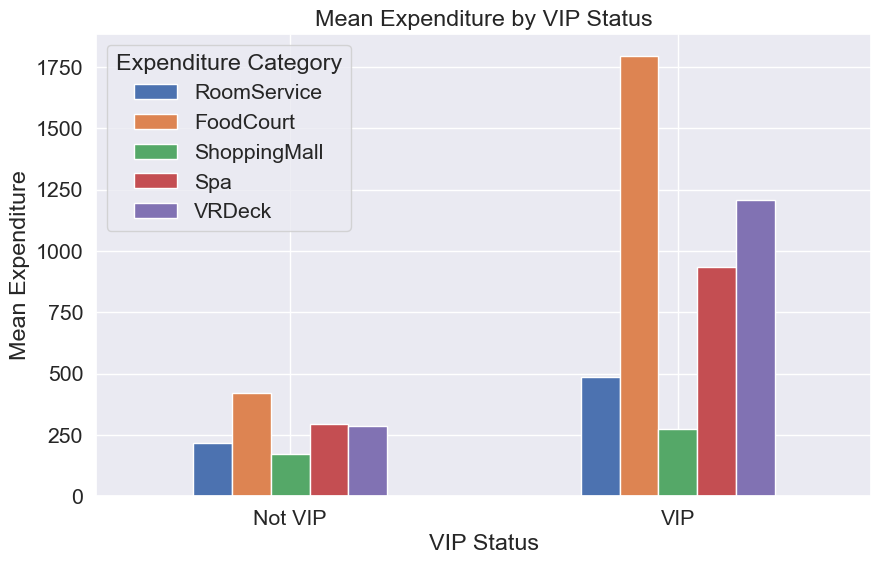

In [332]:
# Group by VIP and calculate the mean expenditure for each category
expenditure_means = dfErnest.groupby('VIP')[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean()

# Plot the bar graph
expenditure_means.plot(kind='bar', figsize=(10, 6))
plt.title('Mean Expenditure by VIP Status')
plt.xlabel('VIP Status')
plt.ylabel('Mean Expenditure')
plt.xticks(ticks=[0, 1], labels=['Not VIP', 'VIP'], rotation=0)
plt.legend(title='Expenditure Category')
plt.show()

In [333]:
# Define a function to predict the VIP status based on expenditure and HomePlanet
def predict_vip(row):
    if row['VRDeck'] > row['Spa']:
        return True
    elif row['Spa'] > row['VRDeck']:
        return False
    else:
        if row['HomePlanet'] == 'Earth':
            return False
        elif row['HomePlanet'] == 'Europa':
            return True
        elif row['HomePlanet'] == 'Mars':
            return True  # If HomePlanet is Mars, VIP should be True
        else:
            return None  # Return None for other cases

def fill_null_vip(df):
    # Apply the function to rows with null values in the VIP column
    df.loc[df['VIP'].isnull(), 'VIP'] = df[df['VIP'].isnull()].apply(predict_vip, axis=1)
    return df

dfErnest = fill_null_vip(dfErnest)

null_vip_count = dfErnest['VIP'].isnull().sum()
print("Number of null values in the VIP column:", null_vip_count)

Number of null values in the VIP column: 0


### Filling null values in the Destination column

- For each destination, how many people from each planet are going there:

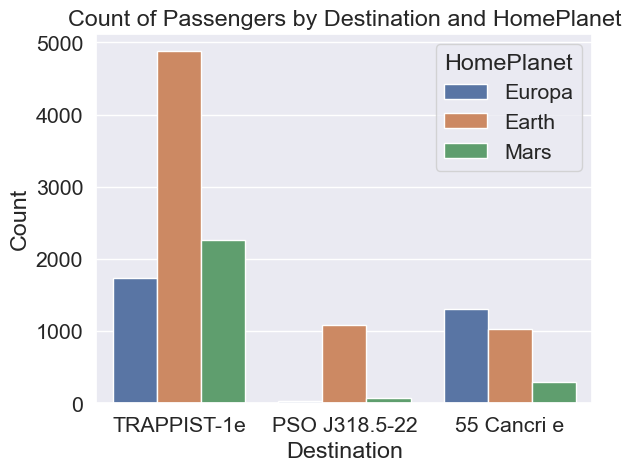

In [335]:
sb.countplot(data=dfErnest, x='Destination', hue='HomePlanet')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Count of Passengers by Destination and HomePlanet')
plt.legend(title='HomePlanet')
plt.show()

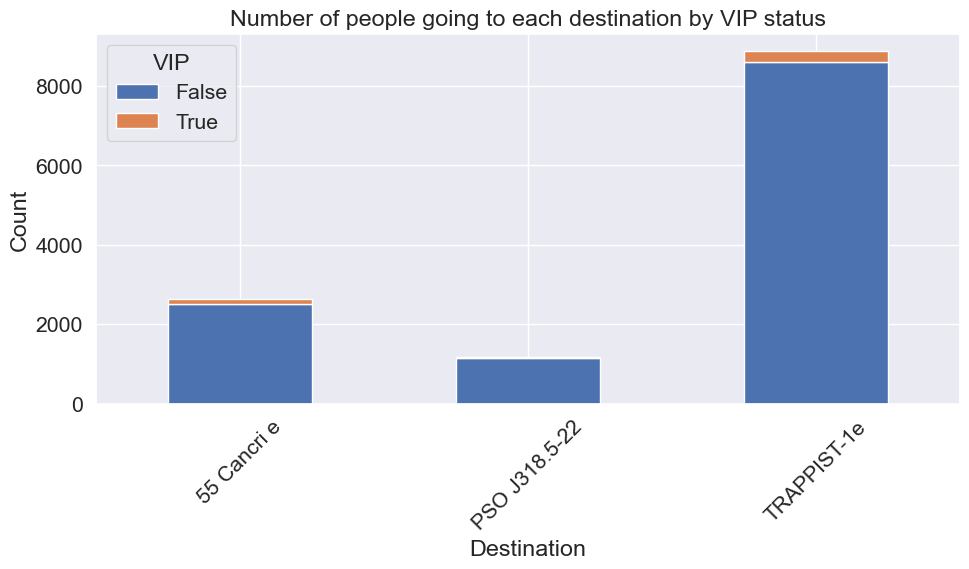

In [336]:
# Group data by Destination and VIP
destination_vip_counts = dfErnest.groupby(['Destination', 'VIP']).size().unstack(fill_value=0)

# Plot the data
destination_vip_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Number of people going to each destination by VIP status')

# Show the plot
plt.legend(title='VIP')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [338]:
def fill_null_destination_by_homeplanet(df): 
    # Fill null values in Destination based on HomePlanet and VIP status
    df.loc[(df['HomePlanet'] == 'Earth') & (df['VIP'] == False) & (df['Destination'].isnull()), 'Destination'] = 'PSO J318.5-22'
    df.loc[(df['HomePlanet'] == 'Earth') & (df['VIP'] == True) & (df['Destination'].isnull()), 'Destination'] = 'TRAPPIST-1e'
    df.loc[(df['HomePlanet'] == 'Europa') & (df['VIP'] == False) & (df['Destination'].isnull()), 'Destination'] = '55 Cancri e'
    df.loc[(df['HomePlanet'] == 'Europa') & (df['VIP'] == True) & (df['Destination'].isnull()), 'Destination'] = 'TRAPPIST-1e'
    df.loc[(df['HomePlanet'] == 'Mars') & (df['VIP'] == False) & (df['Destination'].isnull()), 'Destination'] = '55 Cancri e'
    df.loc[(df['HomePlanet'] == 'Mars') & (df['VIP'] == True) & (df['Destination'].isnull()), 'Destination'] = 'TRAPPIST-1e'
    return df

dfErnest = fill_null_destination_by_homeplanet(dfErnest)

# Count the number of null values in the Destination column
null_destinations = dfErnest['Destination'].isnull().sum()
print("Number of null values in the Destination column:", null_destinations)



Number of null values in the Destination column: 0


In [339]:
# Count the number of null values in the Destination column where VIP column is also null
null_destinations_vip = dfErnest[dfErnest['Destination'].isnull() & dfErnest['VIP'].isnull()].shape[0]
print("Number of null values in the Destination column corresponding to null values in the VIP column:", null_destinations_vip)


Number of null values in the Destination column corresponding to null values in the VIP column: 0


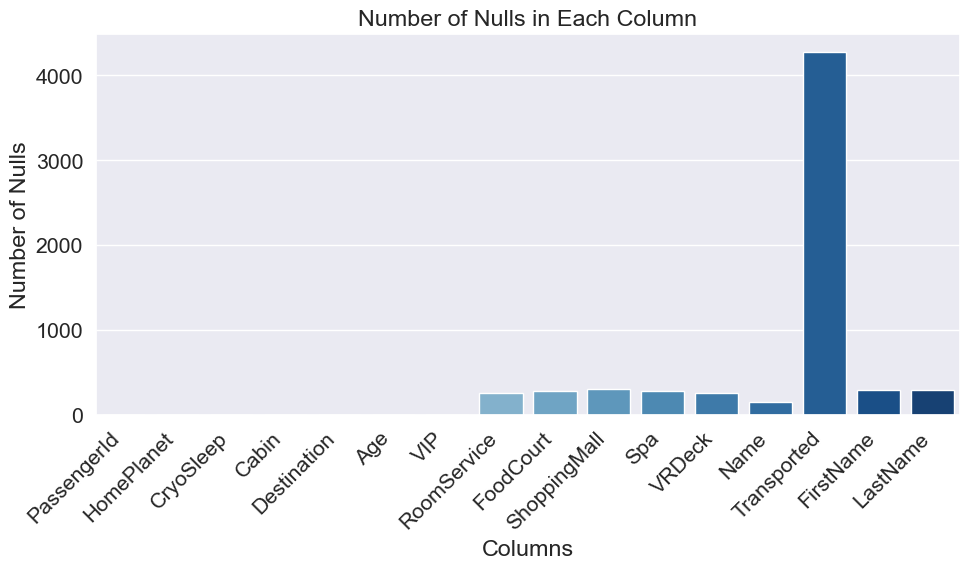

In [350]:
def null_updates_in_dataframe(df):
    # Create empty lists to store column names and null counts
    columns = []
    null_counts = []

    # Iterate over each column and append the column name and null count to the lists
    for column in df.columns:
        null_count = df[column].isnull().sum()
        columns.append(column)
        null_counts.append(null_count)

    # Create a DataFrame from the lists
    null_data = pd.DataFrame({'Column': columns, 'Null Count': null_counts})

    # Plotting
    plt.figure(figsize=(10, 6))
    sb.barplot(data=null_data, x='Column', y='Null Count', palette='Blues')
    plt.xlabel('Columns')
    plt.ylabel('Number of Nulls')
    plt.title('Number of Nulls in Each Column')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()
    
null_updates_in_dataframe(dfErnest)

### Filling null values for the Age:

- Age distribution of People from each Planet:

In [342]:
grouped = dfErnest.groupby('HomePlanet')['Age']

# Calculate quartiles
quartiles = grouped.describe(percentiles=[0.25, 0.5, 0.75])

# Print quartiles in words
for planet, data in quartiles.iterrows():
    print(f"HomePlanet: {planet}")
    print(f"25th Percentile (Q1): {data['25%']:.2f} years")
    print(f"Median (Q2): {data['50%']:.2f} years")
    print(f"75th Percentile (Q3): {data['75%']:.2f} years")
    print("")

HomePlanet: Earth
25th Percentile (Q1): 18.00 years
Median (Q2): 23.00 years
75th Percentile (Q3): 35.00 years

HomePlanet: Europa
25th Percentile (Q1): 26.00 years
Median (Q2): 33.00 years
75th Percentile (Q3): 42.00 years

HomePlanet: Mars
25th Percentile (Q1): 20.00 years
Median (Q2): 28.00 years
75th Percentile (Q3): 38.00 years



In [343]:
null_age_with_zero_spa = dfErnest[dfErnest['Spa'] == 0]['Age'].isnull().sum()
print("Number of null values in the Age column corresponding to Spa being 0:", null_age_with_zero_spa)

Number of null values in the Age column corresponding to Spa being 0: 172


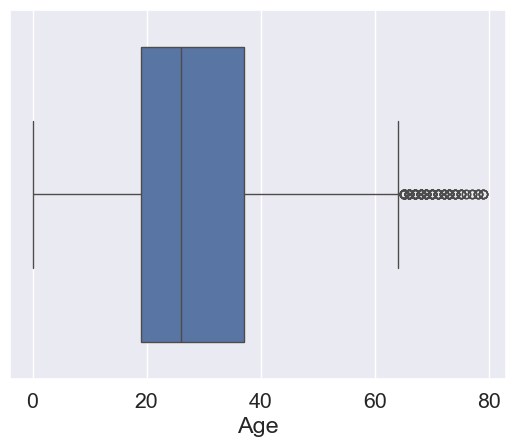

In [ ]:
#Imputing 'Age' null values, but first consider outliers

sb.boxplot(dfErnest['Age'],orient='h')
plt.show()

In [351]:
def fill_null_age(df):
    # Impute null values in Age column where Spa expenditure is 0 with 6
    df.loc[(df['Age'].isnull()) & (df['Spa'] == 0), 'Age'] = 6   
    #get mean for age below 61
    temp = df[df['Age'] < 61]['Age'].mean()
    df['Age'] = df['Age'].fillna(temp) 
    return df

dfErnest = fill_null_age(dfErnest)

null_vip_count = dfErnest['Age'].isnull().sum()
print("Number of null values in the Age column:", null_vip_count)


Number of null values in the Age column: 0


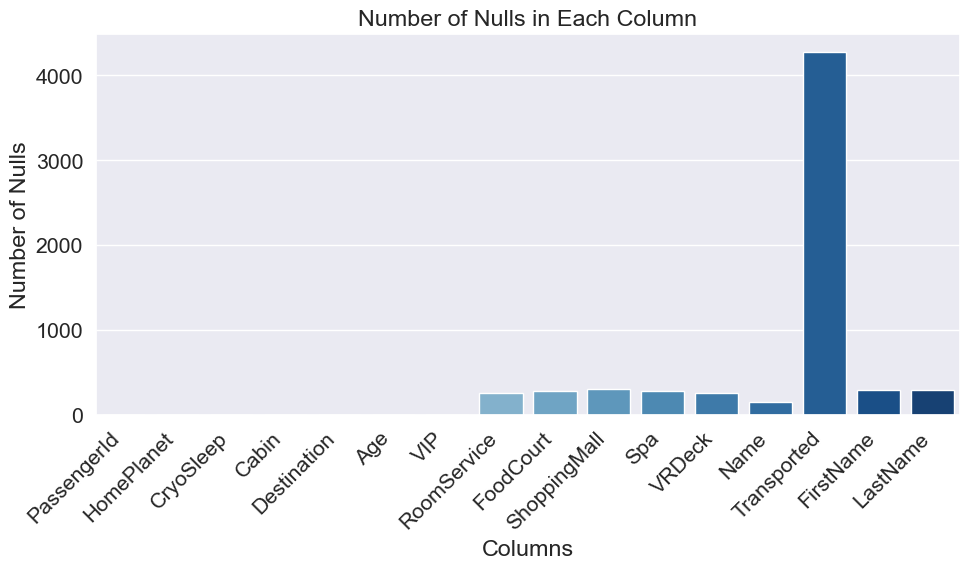

In [352]:
null_updates_in_dataframe(dfErnest)

### Filling null values for RoomService column: 

In [354]:
## Calculate summary statistics for RoomService expenditure for VIP and non-VIP individuals
vip_roomservice_stats = dfErnest[dfErnest['VIP'] == True]['RoomService'].describe()
non_vip_roomservice_stats = dfErnest[dfErnest['VIP'] == False]['RoomService'].describe()

# Display the summary statistics
print("Summary statistics for RoomService expenditure among VIP individuals:")
print(vip_roomservice_stats)
print("\nSummary statistics for RoomService expenditure among non-VIP individuals:")
print(non_vip_roomservice_stats)

Summary statistics for RoomService expenditure among VIP individuals:
count     407.000000
mean      397.862408
std       935.836277
min         0.000000
25%         0.000000
50%         0.000000
75%       402.000000
max      8243.000000
Name: RoomService, dtype: float64

Summary statistics for RoomService expenditure among non-VIP individuals:
count    12300.000000
mean       217.108374
std        635.061083
min          0.000000
25%          0.000000
50%          0.000000
75%         45.000000
max      14327.000000
Name: RoomService, dtype: float64


## Function: calculate_outlier_bounds

Calculate lower and upper bounds for outlier detection using the Interquartile Range (IQR) method.


In [355]:
def calculate_outlier_bounds(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound


- Remove outliers for RoomService expenditures

In [359]:
def fill_null_roomservice(df):
    lower_bound, upper_bound = calculate_outlier_bounds(df['RoomService'])
    df_cleaned = df[(df['RoomService'] >= lower_bound) & (df['RoomService'] <= upper_bound)]

    # Calculate mean and median based on VIP status
    mean_vip = df_cleaned[df_cleaned['VIP'] == True]['RoomService'].mean()
    median_vip = df_cleaned[df_cleaned['VIP'] == True]['RoomService'].median()

    mean_non_vip = df_cleaned[df_cleaned['VIP'] == False]['RoomService'].mean()
    median_non_vip = df_cleaned[df_cleaned['VIP'] == False]['RoomService'].median()

    # Fill null values based on mean and median
    df.loc[(df['VIP'] == True) & (df['RoomService'].isnull()), 'RoomService'] = mean_vip
    df.loc[(df['VIP'] == False) & (df['RoomService'].isnull()), 'RoomService'] = mean_non_vip
    return df

dfErnest= fill_null_roomservice(dfErnest)

null_vip_count = dfErnest['RoomService'].isnull().sum()
print("Number of null values in the RoomService column:", null_vip_count)

Number of null values in the RoomService column: 0


### Filling null values For FoodCourt 

In [360]:
## Calculate summary statistics for FoodCourt expenditure for VIP and non-VIP individuals
vip_foodcourt_stats = dfErnest[dfErnest['VIP'] == True]['FoodCourt'].describe()
non_vip_foodcourt_stats = dfErnest[dfErnest['VIP'] == False]['FoodCourt'].describe()

# Display the summary statistics
print("Summary statistics for FoodCourt expenditure among VIP individuals:")
print(vip_foodcourt_stats)
print("\nSummary statistics for FoodCourt expenditure among non-VIP individuals:")
print(non_vip_foodcourt_stats)

Summary statistics for FoodCourt expenditure among VIP individuals:
count      405.000000
mean      1469.634568
std       3574.431548
min          0.000000
25%          0.000000
50%         13.000000
75%       1260.000000
max      29813.000000
Name: FoodCourt, dtype: float64

Summary statistics for FoodCourt expenditure among non-VIP individuals:
count    12276.000000
mean       418.387423
std       1461.932845
min          0.000000
25%          0.000000
50%          0.000000
75%         60.000000
max      27071.000000
Name: FoodCourt, dtype: float64


- Remove outliers for FoodCourt expenditures

In [362]:
def fill_null_foodcourt(df):
    lower_bound, upper_bound = calculate_outlier_bounds(df['FoodCourt'])
    df_cleaned = df[(df['FoodCourt'] >= lower_bound) & (df['FoodCourt'] <= upper_bound)]

    # Calculate mean and median based on VIP status
    mean_vip = df_cleaned[df_cleaned['VIP'] == True]['FoodCourt'].mean()
    median_vip = df_cleaned[df_cleaned['VIP'] == True]['FoodCourt'].median()

    mean_non_vip = df_cleaned[df_cleaned['VIP'] == False]['FoodCourt'].mean()
    median_non_vip = df_cleaned[df_cleaned['VIP'] == False]['FoodCourt'].median()

    # Fill null values based on mean and median
    df.loc[(df['VIP'] == True) & (df['FoodCourt'].isnull()), 'FoodCourt'] = mean_vip
    df.loc[(df['VIP'] == False) & (df['FoodCourt'].isnull()), 'FoodCourt'] = mean_non_vip
    return df

dfErnest = fill_null_foodcourt(dfErnest)

null_vip_count = dfErnest['FoodCourt'].isnull().sum()
print("Number of null values in the FoodCourt column:", null_vip_count)

Number of null values in the FoodCourt column: 0


### Filling null values For ShoppingMall: 

In [364]:
## Summary statistics for ShoppingMall expenditure among VIP individuals
vip_shopping_stats = dfErnest[dfErnest['VIP'] == True]['ShoppingMall'].describe()
print("Summary statistics for ShoppingMall expenditure among VIP individuals:")
print(vip_shopping_stats)
print()

# Summary statistics for ShoppingMall expenditure among non-VIP individuals
non_vip_shopping_stats = dfErnest[dfErnest['VIP'] == False]['ShoppingMall'].describe()
print("Summary statistics for ShoppingMall expenditure among non-VIP individuals:")
print(non_vip_shopping_stats)


Summary statistics for ShoppingMall expenditure among VIP individuals:
count     405.000000
mean      218.175309
std       517.679525
min         0.000000
25%         0.000000
50%         0.000000
75%       130.000000
max      3700.000000
Name: ShoppingMall, dtype: float64

Summary statistics for ShoppingMall expenditure among non-VIP individuals:
count    12259.000000
mean       173.476548
std        592.778253
min          0.000000
25%          0.000000
50%          0.000000
75%         26.000000
max      23492.000000
Name: ShoppingMall, dtype: float64


- Remove outliers for ShoppingMall expenditures 

In [366]:
def fill_null_shoppingmall(df):
    lower_bound, upper_bound = calculate_outlier_bounds(df['ShoppingMall'])
    df_cleaned = df[(df['ShoppingMall'] >= lower_bound) & (df['ShoppingMall'] <= upper_bound)]

    # Calculate mean and median based on VIP status
    mean_vip = df_cleaned[df_cleaned['VIP'] == True]['ShoppingMall'].mean()
    median_vip = df_cleaned[df_cleaned['VIP'] == True]['ShoppingMall'].median()

    mean_non_vip = df_cleaned[df_cleaned['VIP'] == False]['ShoppingMall'].mean()
    median_non_vip = df_cleaned[df_cleaned['VIP'] == False]['ShoppingMall'].median()

    # Fill null values based on mean and median
    df.loc[(df['VIP'] == True) & (df['ShoppingMall'].isnull()), 'ShoppingMall'] = mean_vip
    df.loc[(df['VIP'] == False) & (df['ShoppingMall'].isnull()), 'ShoppingMall'] = mean_non_vip
    return df

dfErnest = fill_null_shoppingmall(dfErnest)
null_vip_count = dfErnest['ShoppingMall'].isnull().sum()
print("Number of null values in the ShoppingMall column:", null_vip_count)

Number of null values in the ShoppingMall column: 0


### Filling null values for Spa column 

In [368]:
def fill_null_spa(df):
    # Removing outliers from the 'Spa' column using the Interquartile Range (IQR) method
    lower_bound, upper_bound = calculate_outlier_bounds(df['Spa'])

    # Filter out rows with Spa expenditure outside the IQR range
    filtered_df = df[(df['Spa'] >= lower_bound) & (df['Spa'] <= upper_bound)]

    # Calculate mean and median of Spa expenditures for VIP and non-VIP individuals
    mean_spa_vip = filtered_df[filtered_df['VIP'] == True]['Spa'].mean()
    median_spa_vip = filtered_df[filtered_df['VIP'] == True]['Spa'].median()
    mean_spa_non_vip = filtered_df[filtered_df['VIP'] == False]['Spa'].mean()
    median_spa_non_vip = filtered_df[filtered_df['VIP'] == False]['Spa'].median()

    # Fill null values in the 'Spa' column based on VIP status
    df.loc[(df['VIP'] == True) & (df['Spa'].isnull()), 'Spa'] = mean_spa_vip
    df.loc[(df['VIP'] == False) & (df['Spa'].isnull()), 'Spa'] = mean_spa_non_vip
    return df

dfErnest = fill_null_spa(dfErnest)
null_vip_count = dfErnest['Spa'].isnull().sum()
print("Number of null values in the Spa column:", null_vip_count)

Number of null values in the Spa column: 0


### Filling null values for VRDECK column 

-  Removing outliers from the 'VRDeck' column 

In [370]:
def fill_null_vrdeck(df):
    lower_bound, upper_bound = calculate_outlier_bounds(df['VRDeck'])

    # Filter out rows with VRDeck expenditure outside the IQR range
    filtered_df = df[(df['VRDeck'] >= lower_bound) & (df['VRDeck'] <= upper_bound)]

    # Calculate mean and median of VRDeck expenditures for VIP and non-VIP individuals
    mean_vrdeck_vip = filtered_df[filtered_df['VIP'] == True]['VRDeck'].mean()
    median_vrdeck_vip = filtered_df[filtered_df['VIP'] == True]['VRDeck'].median()
    mean_vrdeck_non_vip = filtered_df[filtered_df['VIP'] == False]['VRDeck'].mean()
    median_vrdeck_non_vip = filtered_df[filtered_df['VIP'] == False]['VRDeck'].median()

    # Fill null values in the 'VRDeck' column based on VIP status
    df.loc[(df['VIP'] == True) & (df['VRDeck'].isnull()), 'VRDeck'] = mean_vrdeck_vip
    df.loc[(df['VIP'] == False) & (df['VRDeck'].isnull()), 'VRDeck'] = mean_vrdeck_non_vip
    return df

dfErnest = fill_null_vrdeck(dfErnest)

null_vip_count = dfErnest['VRDeck'].isnull().sum()
print("Number of null values in the VRDeck column:", null_vip_count)

Number of null values in the VRDeck column: 0


### Function for filling all nulls with Approach 3

In [393]:
def fill_null_ernest_approach(df):
    df = fill_null_homeplanet(df)
    df = fill_null_cryosleep(df)
    df = fill_null_cabin_by_group(df)
    df = fill_null_cabin_by_name(df)
    df = fill_null_cabin_by_mode(df)
    df = fill_null_vip(df)
    df = fill_null_destination_by_homeplanet(df)
    df = fill_null_age(df)
    df = fill_null_foodcourt(df)
    df = fill_null_shoppingmall(df)
    df = fill_null_spa(df)
    df = fill_null_vrdeck(df)
    df = fill_null_roomservice(df)
    return df

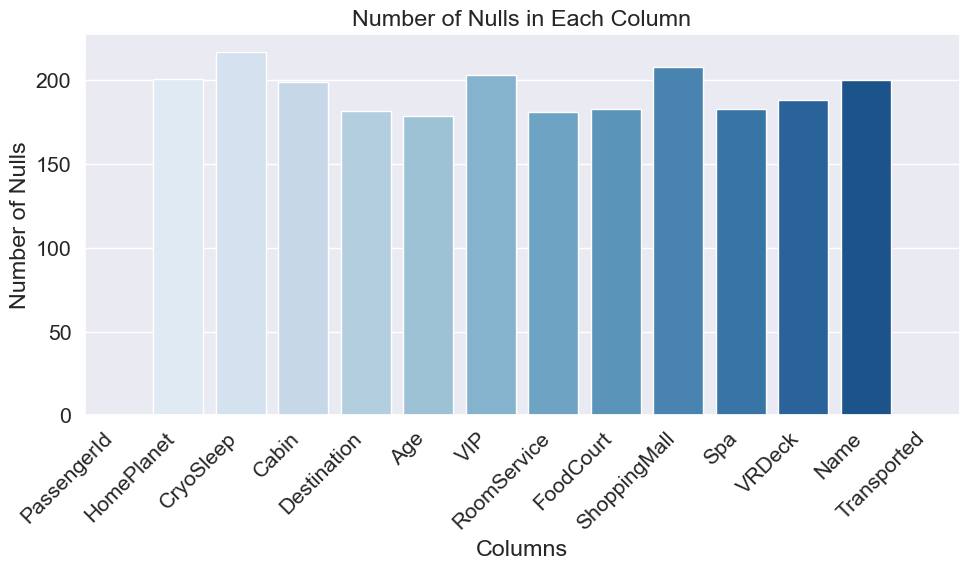

In [388]:
tempdf = pd.read_csv('input/train.csv')
null_updates_in_dataframe(tempdf)

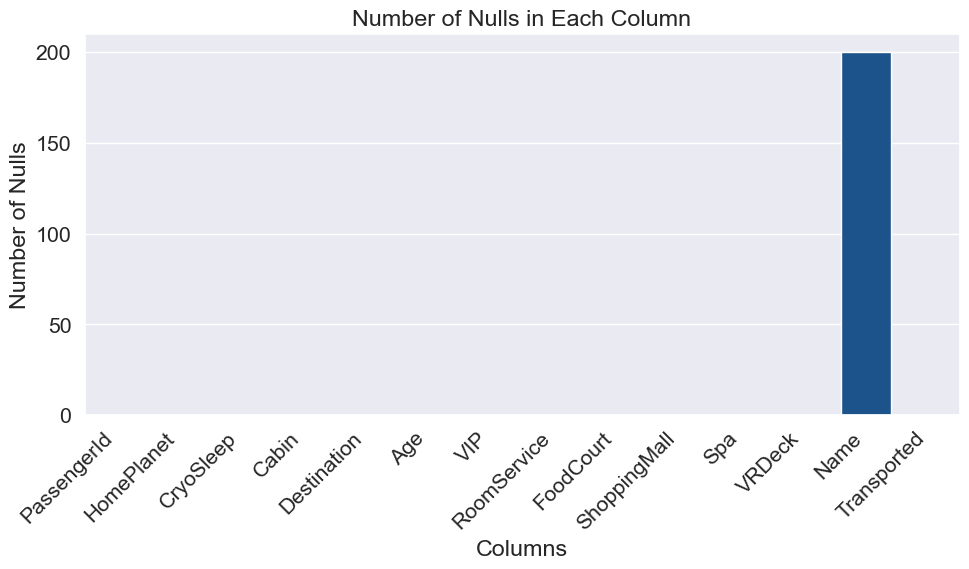

In [394]:

tempdf = fill_null_ernest_approach(tempdf)
null_updates_in_dataframe(tempdf)

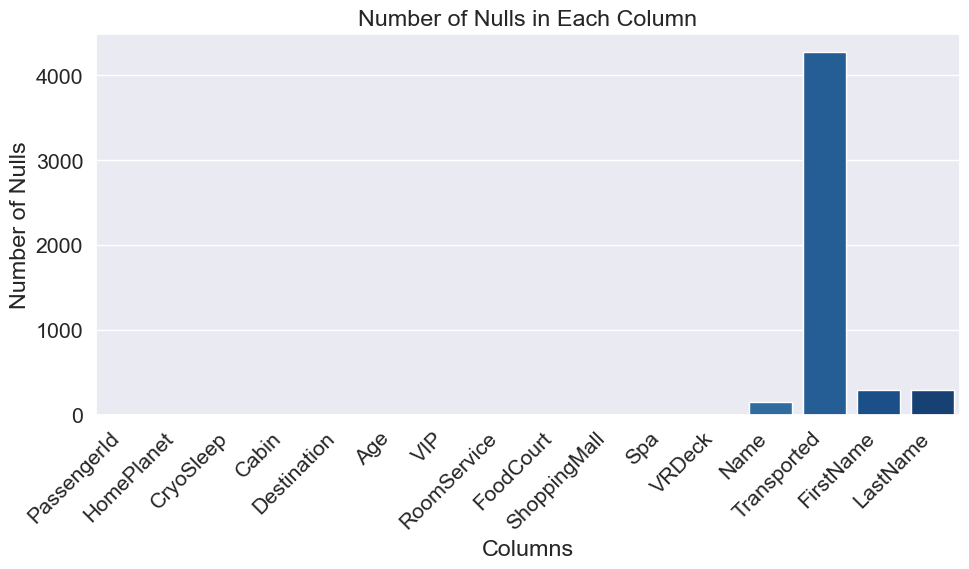

In [372]:
null_updates_in_dataframe(dfErnest)

### Split the combined data back into train and test data 

- Each cleaned data will have a different split 

In [374]:
train_dfAidan, test_dfAidan = separate_df(dfAidan, len(train_df), len(test_df))
train_dfErnest, test_dfErnest = separate_df(dfErnest, len(train_df), len(test_df))


### Splitting the training data into 2 thirds of training data and 1 third of validation set

In [376]:
def train_data_split(df):
    X = df.drop('Transported', axis=1)  # Features
    y = df['Transported'] 

    # Split the data into training and testing sets (2/3 % train, 1/3 % test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)
    return X_train, X_test, y_train, y_test

#For Aidan
X_train, X_validation, y_train, y_validation = train_data_split(train_dfAidan)
X_train.shape,y_train.shape, X_validation.shape, y_validation.shape

#For Ernest
X_train1, X_validation1, y_train1, y_validation1 = train_data_split(train_dfErnest)
X_train1.shape,y_train1.shape, X_validation1.shape, y_validation1.shape

((5795, 15), (5795,), (2898, 15), (2898,))

# Feature Engineering

### Group Features

The PassengerID feature contains data such as group and person number within the group. PassengerID is in the for gggg_pp where gggg stands for the group number and pp stands for the person number within the group. The person number is not considered in this case to be a meaningful feature as each person has a unique number within a group, but it can be used to find the size of a group. The features Group and Group_size are extracted using the extract_Group_Data() function which takes the data as an input.

In [377]:
def extract_Group_Data(data):
    # New feature - Group
    data['Group'] = data['PassengerId'].apply(lambda x: x.split('_')[0]).astype(float)

    # New feature - Group size
    data['Group_size']=data['Group'].map(lambda x: pd.concat([data['Group'], data['Group']]).value_counts()[x])
    
    return data


In [378]:
def plot_Group_Features(data):
    # Plot distribution of new features
    plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    sns.histplot(data=data, x='Group', hue='Transported', binwidth=1)
    plt.title('Group')

    plt.subplot(1,2,2)
    sns.histplot(data=data, x='Group_size', hue='Transported')
    plt.title('Group size')

    return None

In [379]:
train_df = extract_Group_Data(train_df)
test_df = extract_Group_Data(test_df)

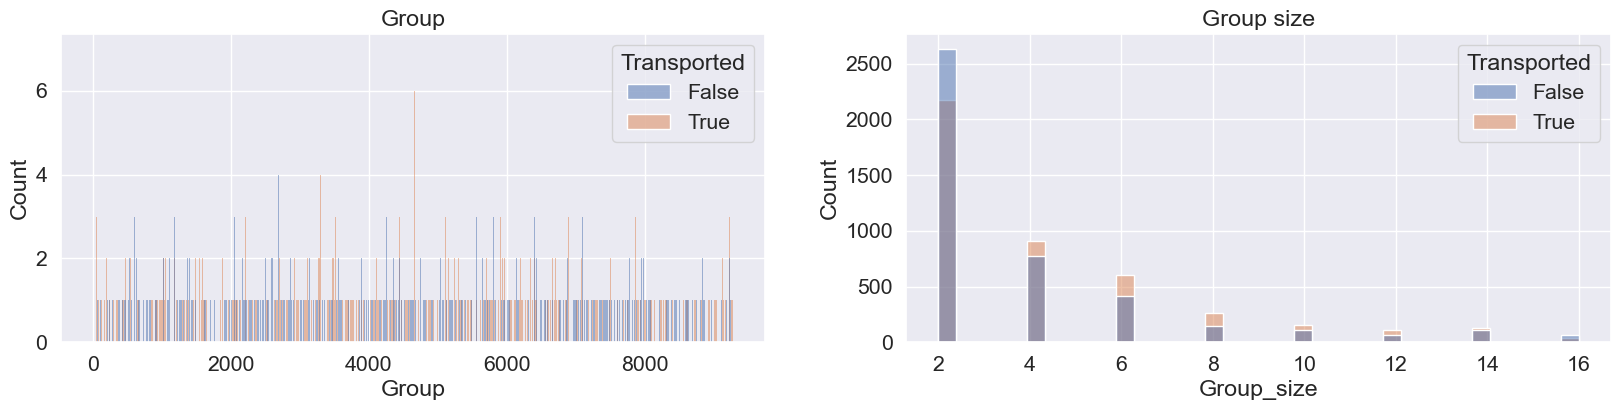

In [380]:
plot_Group_Features(train_df)

### Note:

The Group column has a very high cardinality. High cardinality in categorical features can be taxing for computational resources. When these features are one hot encoded, it creates a lot of extra dimensions in the dataset [Third Eye Data]. Its best to drop this feature.

Group size shows that a passnger is less liekly to be transported than not if they are travelling alone. 
Between group sizes of 2 and 7, passengers were more liekly to be transported. Group sizes of 8 much less likely to be transported than not.

In [381]:
train_df.drop(columns=['Group'])
test_df.drop(columns=['Group'])


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group_size
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,2
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,2
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,2
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,2
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,4
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,2
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,2
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,2


### Cabin Features

The Cabin feature is presented in the form A/1111/S. Where A represents the cabin deck, 1111 represents the cabin number and S represented the cabin side (either S for starboard or P for Portside.). These sub-features of cabin are extracted in the function extract_Cabin_Data(). Once these features are extracted, the Cabin feature is dropped.

In [382]:
def extract_Cabin_Data(data):
    # Fill NaN's 
    data['Cabin'].fillna('Z/9999/Z', inplace=True)
    
    # Enter in new features
    data['Cabin_deck'] = data['Cabin'].apply(lambda x: x.split('/')[0]).astype(object)
    data['Cabin_number'] = data['Cabin'].apply(lambda x: x.split('/')[1]).astype(float)
    data['Cabin_side'] = data['Cabin'].apply(lambda x: x.split('/')[2]).astype(object)

    # Put Nan's back in (These values will be filled later)
    data.loc[data['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
    data.loc[data['Cabin_number']==9999, 'Cabin_number']=np.nan
    data.loc[data['Cabin_side']=='Z', 'Cabin_side']=np.nan

    # Drop Cabin (we don't need it anymore)
    data.drop('Cabin', axis=1, inplace=True)

    return data

In [383]:
def plot_Cabin_Features(data):
    # Plot distribution of new features
    fig=plt.figure(figsize=(10,12))
    plt.subplot(3,1,1)
    sns.histplot(data=data, x='Cabin_deck', hue='Transported')
    plt.title('Cabin deck')

    plt.subplot(3,1,2)
    sns.histplot(data=data, x='Cabin_number', hue='Transported',binwidth=20)
    # # Add lines showing Cabins split by decks
    # plt.vlines(300, ymin=0, ymax=200, color='black')
    # plt.vlines(600, ymin=0, ymax=200, color='black')
    # plt.vlines(900, ymin=0, ymax=200, color='black')
    # plt.vlines(1200, ymin=0, ymax=200, color='black')
    # plt.vlines(1500, ymin=0, ymax=200, color='black')
    # plt.vlines(1800, ymin=0, ymax=200, color='black')
    plt.title('Cabin number')
    plt.xlim([0,2000])

    plt.subplot(3,1,3)
    sns.histplot(data=data, x='Cabin_side', hue='Transported')
    plt.title('Cabin side')
    fig.tight_layout()

    return None

In [384]:
train_df = extract_Cabin_Data(train_df)
test_df = extract_Cabin_Data(test_df)

In [385]:
# plot_Cabin_Features(train_df)

### Note:
* Passengers on Cabin Decks B, G and C were more likely to be Transported than not.
* Passengers on Cabin Decks F, E and D, were less likely to be Transported than not.
* Passengers on Cabin Deckk A were equally likely to be Transported than not.
* Deck T seems to be an outlier with very little sample data.
* Cabin side shows that Passengers on starboard side were more likely to be Transported than passengers on portside.

# Machine Learning Models

Below is all the functionality required to run different datasets over different models.

To handle categorical variables (columns with strings) in the DataFrame, we can perform one-hot encoding. One-hot encoding converts categorical variables into a binary format, where each category becomes a binary feature (0 or 1). This allows machine learning models to handle categorical data effectively.

In [386]:
full_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,FirstName,LastName
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,Jeron,Peter
12966,9269_01,Earth,False,F/126/P,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,Matty,Scheron
12967,9271_01,Mars,True,D/296/P,55 Cancri e,6.0,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,Jayrin,Pore
12968,9273_01,Europa,False,D/297/P,55 Cancri e,6.0,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,Kitakan,Conale


In [101]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
# First, lets separate the data in the cabin column into it's respective pieces of data
full_df = combine_df(train_df, test_df)
cabin_split = full_df['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck', 'Room_Number', 'Side']
new_df = pd.concat([full_df, cabin_split], axis=1)
full_df = new_df
full_df.drop(columns=['Cabin'], inplace=True)
dfControl = full_df

In [114]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def preprocess_and_model(numerical_features, categorical_features, df):
    # Create preprocessing pipelines for numerical and categorical features
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ('inputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine pipelines using ColumnTransformer
    preprocessor = ColumnTransformer([
        ('numerical', numerical_pipeline, numerical_features),
        ('categorical', categorical_pipeline, categorical_features)
    ])
    
    # Set up target
    y = df['Transported']

    # Take target out of the dataframe
    X = df.drop(columns=['Transported'])

    # Y needs to be changed to actual binary values instead of strings
    y = y.astype(bool)

    # Fit data to preprocessor, and clean the data, rename columns to correct names afterwards
    transformed_data = preprocessor.fit_transform(X)

    feature_names = preprocessor.named_transformers_['categorical'] \
        .named_steps['encoder'].get_feature_names_out(input_features=categorical_features) 

    all_feature_names = numerical_features + list(feature_names)

    # Turns data into dataframe
    transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(transformed_df, y, test_size=0.2, random_state=42)

    # Define models
    forest_model = RandomForestClassifier(criterion='gini', n_estimators=70, max_depth=5, min_samples_split=2, min_samples_leaf=2,
                                          max_features='sqrt', random_state=42)
    gb_model = GradientBoostingClassifier(random_state=42)
    logreg_model = LogisticRegression(random_state=42)
    knn_model = KNeighborsClassifier()
    nb_model = GaussianNB()
    linear_svc_model = LinearSVC(random_state=42)
    lgbm_model = LGBMClassifier(random_state=42)
    catboost_model = CatBoostClassifier(random_state=42, verbose=False)

    models = [forest_model, gb_model, logreg_model, knn_model, nb_model, linear_svc_model, lgbm_model, catboost_model]
    model_names = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'KNN', 'Naive Bayes', 'Linear SVC', 'LGBM', 'CatBoost']
    
    accuracies = {}
    
    for model, name in zip(models, model_names):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracies[name] = accuracy
    
    return accuracies

# Example usage:
# Specify numerical and categorical features
numerical_features = ['Room_Number', 'Age', 'RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']
categorical_features = ['HomePlanet','CryoSleep','Destination','VIP','Deck', 'Side']

# Call the function with dfControl as the dataframe
accuracies = preprocess_and_model(numerical_features, categorical_features, dfControl)

# Print accuracies
for model, accuracy in accuracies.items():
    print(f"{model} Accuracy: {accuracy}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6942, number of negative: 3434
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 10376, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.669044 -> initscore=0.703864
[LightGBM] [Info] Start training from score 0.703864
Random Forest Accuracy: 0.7097147262914418
Gradient Boosting Accuracy: 0.7289899768696994
Logistic Regression Accuracy: 0.7023901310717039
KNN Accuracy: 0.7016191210485736
Naive Bayes Accuracy: 0.6958365458750964
Linear SVC Accuracy: 0.7062451811873555
LGBM Accuracy: 0.7297609868928296
CatBoost Accuracy: 0.7301464919043947


In [116]:
# Specify numerical and categorical features for dfErnest
numerical_features_ernest = ['Age', 'Room_Number', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features_ernest = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

# Call the function with dfErnest as the dataframe
accuracies_ernest = preprocess_and_model(numerical_features_ernest, categorical_features_ernest, dfErnest)

# Print accuracies for dfErnest
print("Accuracies for dfErnest:")
for model, accuracy in accuracies_ernest.items():
    print(f"{model} Accuracy: {accuracy}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6899, number of negative: 3473
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1649
[LightGBM] [Info] Number of data points in the train set: 10372, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665156 -> initscore=0.686358
[LightGBM] [Info] Start training from score 0.686358
Accuracies for dfErnest:
Random Forest Accuracy: 0.7274479568234387
Gradient Boosting Accuracy: 0.730917501927525
Logistic Regression Accuracy: 0.7166538164996145
KNN Accuracy: 0.70508866615266
Naive Bayes Accuracy: 0.6942945258288358
Linear SVC Accuracy: 0.7135697764070933
LGBM Accuracy: 0.7417116422513492
CatBoost Accuracy: 0.7316885119506553


In [118]:
# Specify numerical and categorical features for dfAidan
numerical_features_aidan = ['Age', 'Room_Number', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'FamilySize', 'FamilyCount']
categorical_features_aidan = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'Age_Group']

# Call the function with dfAidan as the dataframe
accuracies_aidan = preprocess_and_model(numerical_features_aidan, categorical_features_aidan, dfAidan)

# Print accuracies for dfAidan
print("Accuracies for dfAidan:")
for model, accuracy in accuracies_aidan.items():
    print(f"{model} Accuracy: {accuracy}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6942, number of negative: 3434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1664
[LightGBM] [Info] Number of data points in the train set: 10376, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.669044 -> initscore=0.703864
[LightGBM] [Info] Start training from score 0.703864
Accuracies for dfAidan:
Random Forest Accuracy: 0.7008481110254433
Gradient Boosting Accuracy: 0.7293754818812644
Logistic Regression Accuracy: 0.7093292212798766
KNN Accuracy: 0.6962220508866616
Naive Bayes Accuracy: 0.689668465690054
Linear SVC Accuracy: 0.7124132613723978
LGBM Accuracy: 0.7293754818812644
CatBoost Accuracy: 0.7413261372397841


In [106]:
# Split cabin column into Deck, Room_Number, and Side
cabin_split = dfErnest['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck', 'Room_Number', 'Side']

# Concatenate split columns with dfErnest
dfErnest = pd.concat([dfErnest, cabin_split], axis=1)

# Drop original Cabin column
dfErnest.drop(columns=['Cabin'], inplace=True)


In [112]:
numerical_features_Ernest = ['Room_Number', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features_Ernest = ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'Transported', 'FirstName', 'LastName', 'Deck', 'Side']


In [111]:
dfErnest

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,FirstName,LastName,Deck,Room_Number,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,Maham,Ofracculy,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,Juanna,Vines,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,Altark,Susent,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,Solam,Susent,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,Willy,Santantines,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,Jeron,Peter,G,1496,S
12966,9269_01,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,Matty,Scheron,F,126,P
12967,9271_01,Mars,True,55 Cancri e,6.0,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,Jayrin,Pore,D,296,P
12968,9273_01,Europa,False,55 Cancri e,6.0,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,Kitakan,Conale,D,297,P


In [113]:
# # Example usage for dfAidan
# accuracies_dfAidan = preprocess_and_model(numerical_features, categorical_features, dfAidan)
# for model, accuracy in accuracies_dfAidan.items():
#     print(f"{model} Accuracy: {accuracy}")

# Example usage for dfErnest
accuracies_dfErnest = preprocess_and_model(numerical_features_Ernest, categorical_features_Ernest, dfErnest)
for model, accuracy in accuracies_dfErnest.items():
    print(f"{model} Accuracy: {accuracy}")


ValueError: A given column is not a column of the dataframe

### Breakdown of each model

1. **Random Forest Classifier**: Random Forest is a versatile and widely used ensemble learning method that can handle both numerical and categorical features. It's robust to overfitting and often performs well without much tuning.

2. **XGBoost Classifier**: XGBoost is a powerful gradient boosting framework known for its speed and performance. It can handle missing values and is robust to outliers. XGBoost often achieves state-of-the-art results in machine learning competitions.

3. **Logistic Regression**: Logistic Regression is a simple and interpretable model that is well-suited for binary classification tasks like this one. It provides probability estimates and can handle both numerical and categorical features.

4. **K-Nearest Neighbors (KNN) Classifier**: KNN is a non-parametric method used for classification tasks. It's simple to understand and implement, and it doesn't make strong assumptions about the underlying data distribution.

5. **Gaussian Naive Bayes Classifier**: Naive Bayes is a probabilistic classifier based on Bayes' theorem with the "naive" assumption of independence between features. It's simple, fast, and works well with high-dimensional data.

6. **Linear Support Vector Classifier (Linear SVC)**: Linear SVC is a linear classification model that works well for binary classification tasks. It's effective when the data is linearly separable and provides good generalization performance.

7. **LightGBM Classifier**: LightGBM is a gradient boosting framework that is highly efficient and scalable. It's known for its fast training speed and high accuracy, making it suitable for large datasets.

### Model Evaluation:
Each model's performance is evaluated using accuracy, which measures the proportion of correctly classified instances out of all instances. We use a train-test split of the provided training data to train the models and validate their performance.

### Conclusion:
By employing a variety of machine learning models and carefully evaluating their performance, we aim to identify the best-performing model for predicting whether a passenger was transported to another dimension during the Spaceship Titanic's collision. This approach allows us to explore different modeling techniques and select the one that provides the highest accuracy on the test data, thus optimizing our chances of success in the Kaggle competition.


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedKFold

# Define function for applying different cross-validation (CV) methods
def apply_cv_methods(model, X_train, y_train, cv_methods=['kfold', 'shuffle_split', 'stratified_kfold']):
    results = {}
    for cv_method in cv_methods:
        if cv_method == 'kfold':
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        elif cv_method == 'shuffle_split':
            cv_scores = cross_val_score(model, X_train, y_train, cv=ShuffleSplit(n_splits=5, test_size=0.2), scoring='accuracy')
        elif cv_method == 'stratified_kfold':
            cv_scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED), scoring='accuracy')
        results[cv_method] = cv_scores.mean()
    return results

# Apply BaggingClassifier
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=SEED)
bagging_results = apply_cv_methods(bagging_model, X_train, y_train)
print("Bagging Classifier Results:", bagging_results)

# Apply AdaBoostClassifier
adaboost_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, random_state=SEED)
adaboost_results = apply_cv_methods(adaboost_model, X_train, y_train)
print("AdaBoost Classifier Results:", adaboost_results)


Bagging Classifier Results: {'kfold': 0.7289899159007697, 'shuffle_split': 0.7898792409430706, 'stratified_kfold': 0.7950081756707127}
AdaBoost Classifier Results: {'kfold': 0.6256715398649145, 'shuffle_split': 0.7882691201840137, 'stratified_kfold': 0.79201695880931}


The above code applies ensemble learning techniques, Bagging and AdaBoost, to train Decision Tree classifiers for the Kaggle Spaceship Titanic project. It also evaluates the models using different cross-validation (CV) methods to assess their performance.

### Methodology and Choices:

1. **Ensemble Learning Techniques**: 
   - **Bagging**: It combines multiple decision tree classifiers trained on different subsets of the training data. The final prediction is made by averaging the predictions of all individual classifiers, leading to improved performance and reduced variance.
   - **AdaBoost**: It sequentially trains a series of decision tree classifiers, where each subsequent classifier focuses more on the instances that were misclassified by the previous ones. This iterative approach creates a strong ensemble model by emphasizing the difficult-to-classify instances.

2. **Cross-Validation (CV) Methods**:
   - **k-fold CV**: It partitions the training data into k equal-sized folds, trains the model on k-1 folds, and evaluates it on the remaining fold. This process is repeated k times, ensuring that each data point is used for both training and testing.
   - **Shuffle Split CV**: It randomly shuffles the data and splits it into train/test sets multiple times. This method is useful when the dataset is large and doesn't require exhaustive splitting.
   - **Stratified k-fold CV**: It ensures that each fold contains approximately the same proportion of classes as the entire dataset. This is particularly useful for imbalanced datasets where one class dominates the other.

3. **Model Evaluation**:
   - The code evaluates each model's performance using accuracy scores obtained from cross-validation. Accuracy is a suitable metric for this binary classification task as it measures the proportion of correctly predicted instances out of all instances.

4. **Scikit-Learn Tools**:
   - The code utilizes scikit-learn's efficient implementations of ensemble learning algorithms, cross-validation methods, and decision tree classifiers. Scikit-learn provides a comprehensive toolkit for building, training, and evaluating machine learning models, making it a suitable choice for this project.


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=['Transported']), train_df['Transported'], test_size=0.2, random_state=SEED)

# Preprocess training and test data
X_train_processed = preprocess_data(X_train)
X_test_processed = preprocess_data(X_test)

# Train base models
rf_model.fit(X_train_processed, y_train)
xgb_model.fit(X_train_processed, y_train)
logreg_model.fit(X_train_processed, y_train)
knn_model.fit(X_train_processed, y_train)
nb_model.fit(X_train_processed, y_train)
best_linear_svc.fit(X_train_processed, y_train)
lgbm_model.fit(X_train_processed, y_train)

# Make predictions with base models
rf_predictions = rf_model.predict(X_test_processed)
xgb_predictions = xgb_model.predict(X_test_processed)
logreg_predictions = logreg_model.predict(X_test_processed)
knn_predictions = knn_model.predict(X_test_processed)
nb_predictions = nb_model.predict(X_test_processed)
best_linear_svc_predictions = best_linear_svc.predict(X_test_processed)
lgbm_predictions = lgbm_model.predict(X_test_processed)

# Stack the predictions
stacked_features = np.column_stack((rf_predictions, xgb_predictions, logreg_predictions, knn_predictions, 
                                    nb_predictions, best_linear_svc_predictions, lgbm_predictions))

# Train the meta-model
meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_test)

# Make predictions with the meta-model
meta_predictions = meta_model.predict(stacked_features)

# Score the predictions and print them
meta_accuracy = accuracy_score(y_test, meta_predictions)
print("Meta-model Accuracy:", meta_accuracy)


[LightGBM] [Info] Number of positive: 3490, number of negative: 3464
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2416
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501869 -> initscore=0.007478
[LightGBM] [Info] Start training from score 0.007478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

# Self-learning

In the journey of mastering machine learning, one of the most profound concepts I encountered is self-learning. Self-learning entails the process of continuously acquiring knowledge and skills without direct human intervention, driven solely by the data and algorithms at one's disposal.

Throughout this project, I embarked on a quest to understand and implement various machine learning models to predict whether passengers aboard the Spaceship Titanic were transported to an alternate dimension during its collision with a spacetime anomaly. This endeavor led me to explore a plethora of models, each with its unique complexities and intricacies.

One principle that resonated deeply with me during this journey is Occam's Razor. Occam's Razor suggests that when faced with multiple competing hypotheses, the simplest one is often the correct one. This principle served as a guiding light, especially when dealing with missing data. Despite the availability of sophisticated imputation techniques, such as KNN or regression-based imputation, I found that using the mean to replace NaN values often yielded satisfactory results. This simplicity not only streamlined the preprocessing pipeline but also mitigated the risk of overfitting.

Moreover, the iterative process of experimenting with different models and techniques reinforced the importance of adaptability and resilience in the face of challenges. For instance, while exploring ensemble learning methods like Bagging and AdaBoost, I discovered the power of combining multiple weak learners to create a robust predictive model. These ensemble techniques not only improved predictive performance but also provided insights into the inherent trade-offs between bias and variance.

Furthermore, the project underscored the significance of cross-validation in model evaluation. By leveraging k-fold, shuffle split, and stratified k-fold cross-validation methods, I gained a deeper understanding of each model's generalization capabilities and identified potential sources of bias or variance. This iterative validation process not only enhanced model robustness but also fostered a deeper appreciation for the nuances of model selection and evaluation.

In essence, the journey of self-learning in machine learning is a perpetual quest for knowledge, marked by curiosity, experimentation, and adaptation. It is a journey that transcends traditional boundaries, empowering individuals to navigate the vast expanse of data-driven insights and unearth transformative discoveries.



## Function: hyperparameter_tuning

This function performs hyperparameter tuning for a given model using either GridSearchCV or RandomizedSearchCV from scikit-learn.

### Parameters:
- `model`: Scikit-learn estimator object.
- `param_grid` (dict): Dictionary with hyperparameter names as keys and lists of hyperparameter values to try.
- `X_train` (array-like): Feature matrix of training data.
- `y_train` (array-like): Target vector of training data.
- `cv` (int, cross-validation generator, or an iterable): Determines the cross-validation splitting strategy. Default is 5-fold cross-validation.
- `search_type` (str): Type of hyperparameter search, either 'grid' for GridSearchCV or 'random' for RandomizedSearchCV. Default is 'grid'.

### Returns:
- `best_estimator`: Fitted model with the best hyperparameters found during the search.

### Example Usage:
```python
from sklearn.svm import SVC

# Define parameter grid for SVC
svc_param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01], 'kernel': ['linear', 'rbf']}

# Perform hyperparameter tuning for SVC
best_svc = hyperparameter_tuning(SVC(), svc_param_grid, X_train, y_train)


In [ ]:
def hyperparameter_tuning(model, param_grid, X_train, y_train, cv=5, search_type='grid'): 
    if search_type == 'grid':
        search = GridSearchCV(model, param_grid, cv=cv, verbose=2, n_jobs=-1)
    elif search_type == 'random':
        search = RandomizedSearchCV(model, param_grid, cv=cv, verbose=2, n_jobs=-1)
    else:
        raise ValueError("Invalid search_type. Choose either 'grid' or 'random'.")

    search.fit(X_train, y_train)
    best_estimator = search.best_estimator_
    
    return best_estimator

## Application of the hyperparameter_tuning function

In [ ]:
#1. Random Forest
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

# Apply hyperparameter tuning
best_rf_model = hyperparameter_tuning(rf_model, rf_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_rf_model.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy after Hyperparameter Tuning:", rf_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#2. Linear SVC

# Define the parameter grid for Linear SVC
param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Apply hyperparameter tuning
best_linear_svc = hyperparameter_tuning(LinearSVC(), param_grid_svc, X_train, y_train, search_type='random')

# Fit the best model on the training data
best_linear_svc.fit(X_train, y_train)

# Predict on the test data
y_pred_svc = best_linear_svc.predict(X_test)

# Calculate accuracy
svc_accuracy = accuracy_score(y_test, y_pred_svc)

print("Linear SVC Accuracy after Hyperparameter Tuning:", svc_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#3.For LGBMClassifier
# Define the parameter grid for LGBMClassifier
param_grid_lgbm = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10, 12],
    'num_leaves': [20, 30, 40],
    'n_estimators': [50, 100, 200]
}

# Apply hyperparameter tuning
best_lgbm_model = hyperparameter_tuning(LGBMClassifier(random_state=42), param_grid_lgbm, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_lgbm_model.fit(X_train, y_train)

# Predict on the test data
y_pred_lgbm = best_lgbm_model.predict(X_test)

# Calculate accuracy
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
print("LGBMClassifier Accuracy after Hyperparameter Tuning:", lgbm_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#4.For Pipeline:
# Define parameter grid
param_grid_svc = {
    "model__C": [0.001, 0.01, 0.1, 1, 10],
    "model__gamma": ["scale", "auto"],
    "model__kernel": ["rbf"]
}

# Perform hyperparameter tuning with your function
best_pipe6 = hyperparameter_tuning(pipe6, param_grid_svc, X_train, y_train, cv=5, search_type='random')


# Evaluate the best estimator
pipe6_accuracy = best_pipe6.score(X_test, y_test)
print("PipeLine Accuracy after Hyperparameter Tuning:", pipe6_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#5.For Logistic Regression:
# Define the parameter grid for Logistic Regression
logreg_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Apply hyperparameter tuning
best_logreg_model = hyperparameter_tuning(logreg_model, logreg_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_logreg_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_logreg_model.predict(X_test)

# Calculate accuracy
logreg_accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy after Hyperparameter Tuning:", logreg_accuracy)
#----------------------------------------------------------------------------------------------------------------------------

#6.For XGBoost:

# Define the parameter grid for XGBoost Classifier
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Apply hyperparameter tuning
best_xgb_model = hyperparameter_tuning(xgb_model, xgb_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_xgb_model.predict(X_test)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Classifier Accuracy after Hyperparameter Tuning:", xgb_accuracy)
#----------------------------------------------------------------------------------------------------------------------------
#7.For KNN:

# Define the parameter grid for KNN Classifier
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # For Minkowski distance (1 for Manhattan, 2 for Euclidean)
}

# Apply hyperparameter tuning
best_knn_model = hyperparameter_tuning(knn_model, knn_param_grid, X_train, y_train, search_type='grid')

# Fit the best model on the training data
best_knn_model.fit(X_train, y_train)

# Predict on the test data
y_pred = best_knn_model.predict(X_test)

# Calculate accuracy
knn_accuracy = accuracy_score(y_test, y_pred)
print("KNN Classifier Accuracy after Hyperparameter Tuning:", knn_accuracy)
#----------------------------------------------------------------------------------------------------------------------------
#8.For Gaussian Naive Bayes
#Since NB doesn't have hyperparameters to tune, you don't need to perform hyperparameter tuning.
#Instead, you can directly evaluate its performance using cross-validation.

# Perform cross-validation
nb_scores = cross_val_score(nb_model, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation Scores:", nb_scores)

# Calculate and print the mean accuracy
nb_mean_accuracy = nb_scores.mean()
print("Mean Accuracy:", nb_mean_accuracy)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jessd\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jessd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_forest.py", line 346, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jessd\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 554, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jessd\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py", line 1104, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\jessd\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py", line 919, in check_array
    _assert_all_finite(
  File "C:\Users\jessd\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py", line 161, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


# References
### [1] Bargagli Stoffi, F.J., Cevolani, G. and Gnecco, G., 2022. Simple models in complex worlds: Occam’s razor and statistical learning theory. Minds and Machines, 32(1), pp.13-42.